#[Your_name]

<h1 style="text-align: center;">Data Exploratory Analysis and Processing<h1>

Prepare libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from pathlib import Path
import geopandas as gpd
# from shapely import multilinestrings
import shapely as sp
import geohash
from scipy.stats import pointbiserialr,chi2_contingency
import seaborn as sns
from shapely.geometry import MultiLineString, MultiPolygon,Point
from shapely.wkt import loads
from shapely.ops import transform
from functools import partial
import pyproj
from sklearn.impute import SimpleImputer
import h3
from sklearn.cluster import KMeans

# from pygis import io, index


Download data

In [4]:
beat_boundaries = pd.read_csv(Path("../chicago-traffic-dataset/chicago-police-beat-boundries.csv"))
CBD_boundary = pd.read_csv(Path("../chicago-traffic-dataset/chicago-CBD-boundary.csv"))
center_lines = pd.read_csv(Path("../chicago-traffic-dataset/chicago-street-center-lines.csv"))
traffic_crashes = pd.read_csv(Path("../chicago-traffic-dataset/traffic-crashes.csv"))
traffic_crashes_people = pd.read_csv(Path("../chicago-traffic-dataset/traffic-crashes-people.csv"))
traffic_crashes_vehicles = pd.read_csv(Path("../chicago-traffic-dataset/traffic-crashes-vehicles.csv"))

C:\Users\DELL\AppData\Local\Temp\ipykernel_12480\335421803.py:5: DtypeWarning: Columns (19,23,24,25,28) have mixed types. Specify dtype option on import or set low_memory=False.
  traffic_crashes_people = pd.read_csv(Path("../chicago-traffic-dataset/traffic-crashes-people.csv"))
C:\Users\DELL\AppData\Local\Temp\ipykernel_12480\335421803.py:6: DtypeWarning: Columns (17,19,38,39,40,42,46,47,48,51,53,56,57,58,59,69) have mixed types. Specify dtype option on import or set low_memory=False.
  traffic_crashes_vehicles = pd.read_csv(Path("../chicago-traffic-dataset/traffic-crashes-vehicles.csv"))


# Question [1]: Data Cleaning & Integration

## [a] Fill Gaps

### BEAT BOUNDARIES

### CITY CENTER LINES

##### 1- Dropping the columns

- with too few values

In [5]:
center_lines.drop(columns=['FLAG_STRIN', 'EDIT_TYPE', 'SUF_DIR'], inplace=True)

- irrelevant data

Since 'TRANS_ID' is not directly related to the crashes and we have no data about the transportions and we can't dig any further
'TRANS_ID' will be dropped

In [6]:
center_lines.drop('TRANS_ID', axis=1, inplace=True)

We're not concerened with the date of the last time a value was updated or created so we'll drop some meta data

In [7]:
center_lines.drop(columns=['CREATE_USE', 'CREATE_TIM', 'UPDATE_USE','UPDATE_TIM', 'STATUS_DAT'], inplace=True)

the postal info (ZIP codes) are not relevant

In [8]:
center_lines.drop(columns=[ 'R_ZIP', 'L_ZIP'], inplace=True )

- Removing every unknown or unrelated column

In [9]:
center_lines.drop(columns=['LOGICLF', 'LOGICLT', 'LOGICRT','LOGICRF', 'L_F_ADD', 'L_T_ADD', 'L_PARITY', 'R_PARITY', 'R_F_ADD', 'R_T_ADD'], inplace=True)

In [10]:
center_lines.drop(columns=['R_CENSUSBL', 'L_CENSUSBL', 'EDIT_DATE', 'L_FIPS', 'R_FIPS'], inplace=True)

- unnecessary data

By looking at 'LENGTH' and 'SHAPE_LEN' on the first look they seem identical.
let's look in to this

In [11]:
print(center_lines['LENGTH'].corr(center_lines['SHAPE_LEN']))

0.999999064215188


they're truly nearly identical by checking the correlation.
let's plot it before dropping it

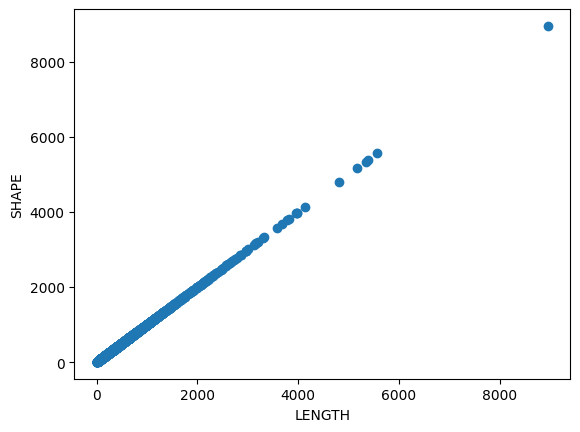

In [12]:

plt.scatter(center_lines['LENGTH'], center_lines['SHAPE_LEN'])
plt.xlabel('LENGTH')
plt.ylabel('SHAPE')
plt.show()


it's perfectly diagonal. which means we have nearly the same exact column. let's drop it

In [13]:
center_lines.drop('SHAPE_LEN', axis=1, inplace=True)

##### 2- Filling Missing Values

in the 'STREET_NAM' there are nearly 500 missing values. it's convinient to delete the related rows as it's only ones in the 'STREETNAME' column

In [14]:
filter_null_street_name = center_lines[center_lines['STREET_NAM'].isnull()]

In [15]:
print(filter_null_street_name['STREETNAME'])

265      1
376      1
438      1
443      1
566      1
        ..
55338    1
55339    1
55378    1
55612    1
55613    1
Name: STREETNAME, Length: 454, dtype: int64


In [16]:
print(filter_null_street_name['STREETNAME'].value_counts())

STREETNAME
1    454
Name: count, dtype: int64


now that we made sure it's always null and has the same values in the 'STREETNAME' which is the only other street indicator we'll delete those rows

In [17]:
center_lines = center_lines.dropna(subset='STREET_NAM')

In [18]:
center_lines.isnull().sum()

the_geom          0
FNODE_ID          0
TNODE_ID          0
PRE_DIR           0
STREET_NAM        0
STREET_TYP      800
STREETNAME        0
CLASS             0
STATUS            6
TIERED            0
ONEWAY_DIR    35999
DIR_TRAVEL        0
EWNS              0
F_ZLEV            0
T_ZLEV            0
F_CROSS           0
F_CROSS_ST        0
T_CROSS           0
T_CROSS_ST        0
LENGTH            0
EWNS_DIR       7325
EWNS_COORD        0
dtype: int64

In [ ]:
center_lines.info()

the 'ONEWAY_DIR' value describes the direction of the road when it's in fact a one direction street.
it leaves all the streets with two directions empty
we'll fill it with a new value 'B' which stand for "Both directions"  

In [20]:
center_lines['ONEWAY_DIR'].fillna('B', inplace=True)

In [ ]:
center_lines.isnull().sum()

STREET_TYP has some values that need to be filled

In [ ]:
center_lines['STREET_TYP'].value_counts()

In [23]:
traffic_crashes_people['PEDPEDAL_ACTION'].unique()

array([nan, 'CROSSING - WITH SIGNAL', 'NO ACTION', 'STANDING IN ROADWAY',
       'PARKED VEHICLE', 'CROSSING - NO CONTROLS (NOT AT INTERSECTION)',
       'OTHER ACTION',
       'CROSSING - CONTROLS PRESENT (NOT AT INTERSECTION)',
       'WITH TRAFFIC', 'UNKNOWN/NA',
       'CROSSING - NO CONTROLS (AT INTERSECTION)', 'NOT AT INTERSECTION',
       'CROSSING - AGAINST SIGNAL', 'TURNING RIGHT', 'AGAINST TRAFFIC',
       'WORKING IN ROADWAY', 'INTOXICATED PED/PEDAL', 'TURNING LEFT',
       'ENTER FROM DRIVE/ALLEY', 'PLAYING/WORKING ON VEHICLE',
       'PLAYING IN ROADWAY', 'SCHOOL BUS (WITHIN 50 FT.)',
       'TO/FROM DISABLED VEHICLE', 'WAITING FOR SCHOOL BUS'], dtype=object)

In [24]:
imputer = SimpleImputer(strategy='most_frequent')  # or strategy='constant', fill_value='Unknown'

# Fit the imputer on the column with missing values
# The imputer learns the most frequent value in the 'STREET_TYP' column
imputer.fit(center_lines[['STREET_TYP']])

# Transform the column and fill missing values
# The imputer applies the learned most frequent value to the missing entries
center_lines['STREET_TYP'] = imputer.transform(center_lines[['STREET_TYP']]).ravel()

# Now the 'STREET_TYP' column has missing values imputed


In [25]:
center_lines.isnull().sum()

the_geom         0
FNODE_ID         0
TNODE_ID         0
PRE_DIR          0
STREET_NAM       0
STREET_TYP       0
STREETNAME       0
CLASS            0
STATUS           6
TIERED           0
ONEWAY_DIR       0
DIR_TRAVEL       0
EWNS             0
F_ZLEV           0
T_ZLEV           0
F_CROSS          0
F_CROSS_ST       0
T_CROSS          0
T_CROSS_ST       0
LENGTH           0
EWNS_DIR      7325
EWNS_COORD       0
dtype: int64

Now with EWNS_DIR

In [26]:
center_lines['EWNS_DIR'].unique()

array(['W', nan, 'S', 'N', 'E'], dtype=object)

Let's find out if the direction is set by the street geometry 

In [27]:
def get_direction(multilinestring):
    multilinestring = loads(multilinestring)
    directions = []
    for line in multilinestring.geoms :
        start_point = line.coords[0]
        end_point = line.coords[-1]
        delta_x = end_point[0] - start_point[0]
        delta_y = end_point[1] - start_point[1]
        
        angle = np.arctan2(delta_y, delta_x)
        angle_deg = np.degrees(angle) % 360
        
        if angle_deg >= 45 and angle_deg < 135:
            directions.append('N')
        elif angle_deg >= 135 and angle_deg < 225:
            directions.append('W')
        elif angle_deg >= 225 and angle_deg < 315:
            directions.append('S')
        else:
            directions.append('E')

        
    unique_elements, counts = np.unique(directions, return_counts=True)
    max_count_index = np.argmax(counts)
        
    
    return unique_elements[max_count_index]

In [28]:
geometry_directions = center_lines['the_geom'].apply(get_direction)

In [29]:
geometry_directions.unique()

array(['S', 'W', 'N', 'E'], dtype=object)

now that we have predicted the values let's compare them

In [30]:

# Create a DataFrame by merging the Series
comparisson = pd.DataFrame({'ORIGINAL': center_lines['EWNS_DIR'], 'PREDICTED': geometry_directions})

# Drop rows with null values
comparisson = comparisson.dropna()

In [31]:

# Create crosstab
crosstab = pd.crosstab(comparisson['ORIGINAL'], comparisson['PREDICTED'])

# Analyze the crosstab to understand the relationship between the categories
print(crosstab)


PREDICTED     E     N      S     W
ORIGINAL                          
E            35   179   3703    61
N           210    14     10  9229
S          4332    15     16  9964
W           299  9239  10291   371


the correct predictions are very few. let's change our approach in calculating the direction by getting the last direction in the street instead of the most occurred value

but first let's take a look at how many directions there are in every MultiLineString 

In [32]:
def get_lines_count(multilinestring):
    multilinestring = loads(multilinestring)
    
    return len(multilinestring.geoms)

In [33]:
lines = center_lines['the_geom'].apply(get_lines_count)

In [34]:
lines.unique()

array([1], dtype=int64)

In [35]:
lines.info()

<class 'pandas.core.series.Series'>
Index: 55293 entries, 0 to 55746
Series name: the_geom
Non-Null Count  Dtype
--------------  -----
55293 non-null  int64
dtypes: int64(1)
memory usage: 864.0 KB


so every street has only two points

that limits the probabilty of wrong calculations let's have another look at the data

In [36]:

# Create crosstab
crosstab = pd.crosstab(comparisson['ORIGINAL'], comparisson['PREDICTED'])

# Analyze the crosstab to understand the relationship between the categories
print(crosstab)


PREDICTED     E     N      S     W
ORIGINAL                          
E            35   179   3703    61
N           210    14     10  9229
S          4332    15     16  9964
W           299  9239  10291   371


let's draw a better visualization for this

![alt text](temp.jpeg)

the large cross is the prediction values while the small crosses are the actual values 

the arrows indicates the direction of the best direction estimation that should've been in this prediction.

 the values are intertwined and showing no patterns of any relation between the two set of values. not if rotated nor if flipped. (no regular transformation will get the original value)

this indicates that we actually don't quite understand this attribute and therefore we better drop it since there's no correct way to fill the missing values

specially that we can't fill it with dummy values since it's location related and there are multiple other geodata. so filling the missing values with dummy values will contradict the data.

In [37]:
info_df = (center_lines['EWNS_DIR'].isnull().sum() / center_lines['EWNS_DIR'].shape[0] * 100).round().astype(int)
info_df

13

with a big percentage of 13% loss it's not convenient to drop the instances so we'll drop the attribute instead

In [38]:
center_lines = center_lines.dropna(subset='EWNS_DIR')

In [39]:
center_lines['STATUS'].unique()

array(['N', 'P', 'V', 'C', 'UC', nan], dtype=object)

In [40]:
# Calculate the most frequent value for each column
most_frequent_col1 = center_lines['STATUS'].mode().iloc[0]

# Fill NaN values with the most frequent value
center_lines['STATUS'].fillna(most_frequent_col1, inplace=True)

#### TRAFFIC CRASHES

##### Dropping Columns that contains alot null values and useless

In [41]:
traffic_crashes.drop(columns=['CRASH_DATE_EST_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_TYPE', 'WORK_ZONE_I',
                               'WORKERS_PRESENT_I', 'INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I','HIT_AND_RUN_I',
                               'PHOTOS_TAKEN_I','INJURIES_INCAPACITATING','INJURIES_NON_INCAPACITATING',
                               'INJURIES_REPORTED_NOT_EVIDENT','INJURIES_NO_INDICATION','INJURIES_UNKNOWN',
                               'INJURIES_FATAL','INJURIES_TOTAL','MOST_SEVERE_INJURY','LANE_CNT'
                               ], inplace=True)


##### Fill null's value in this column by most frequent item

In [42]:
traffic_crashes['REPORT_TYPE'].fillna(value='NOT ON SCENE (DESK REPORT)',inplace=True)


In [43]:
# Create a boolean mask to identify rows where both 'column1' and 'column2' are 0.0
mask = (traffic_crashes['LONGITUDE'] != 0.0) | (traffic_crashes['LATITUDE'] != 0.0)

# Drop the rows where the mask is False (both 'column1' and 'column2' are 0.0)
traffic_filterd = traffic_crashes[mask]

print("Original DataFrame:")
print(traffic_crashes.info())
print("\nFiltered DataFrame:")
print(traffic_filterd.info())

Original DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823957 entries, 0 to 823956
Data columns (total 28 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   CRASH_RECORD_ID          823957 non-null  object 
 1   CRASH_DATE               823957 non-null  object 
 2   POSTED_SPEED_LIMIT       823957 non-null  int64  
 3   TRAFFIC_CONTROL_DEVICE   823957 non-null  object 
 4   DEVICE_CONDITION         823957 non-null  object 
 5   WEATHER_CONDITION        823957 non-null  object 
 6   LIGHTING_CONDITION       823957 non-null  object 
 7   FIRST_CRASH_TYPE         823957 non-null  object 
 8   TRAFFICWAY_TYPE          823957 non-null  object 
 9   ALIGNMENT                823957 non-null  object 
 10  ROADWAY_SURFACE_COND     823957 non-null  object 
 11  ROAD_DEFECT              823957 non-null  object 
 12  REPORT_TYPE              823957 non-null  object 
 13  CRASH_TYPE               823957 non-nul

In [44]:
traffic_crashes = traffic_filterd

In [45]:
mean = traffic_crashes['LONGITUDE'].mean()
print(f'LANE_CNT Average: {mean}')
traffic_crashes['LONGITUDE'].fillna(value=mean,inplace=True)

mean = traffic_crashes['LATITUDE'].mean()
print(f'LANE_CNT Average: {mean}')
traffic_crashes['LATITUDE'].fillna(value=mean,inplace=True)

LANE_CNT Average: -87.67884612178757
LANE_CNT Average: 41.85741450431183


### Fill Location Column with most frequent data 

In [46]:
traffic_crashes['LOCATION'].fillna(value='POINT (-87.723458737142 41.798505044022)',inplace=True)

#### VEHICLE CRASHES

#### Dropping useless column or that contains alot of null values 

In [47]:
traffic_crashes_vehicles.drop(columns=['CMRC_VEH_I','TOWED_I','FIRE_I','EXCEED_SPEED_LIMIT_I','TOWED_BY','TOWED_TO',
                          'AREA_00_I','AREA_01_I','AREA_02_I','AREA_03_I','AREA_04_I','AREA_05_I','AREA_06_I','AREA_07_I',
                          'AREA_08_I','AREA_09_I','AREA_10_I','AREA_11_I','AREA_12_I','AREA_99_I','CMV_ID','USDOT_NO',
                          'CCMC_NO','ILCC_NO','COMMERCIAL_SRC','GVWR','CARRIER_NAME','CARRIER_STATE','CARRIER_CITY',
                          'HAZMAT_PLACARDS_I','HAZMAT_NAME','UN_NO','HAZMAT_PRESENT_I','HAZMAT_REPORT_I',
                          'HAZMAT_REPORT_NO','MCS_REPORT_I','MCS_REPORT_NO','HAZMAT_VIO_CAUSE_CRASH_I',
                          'MCS_VIO_CAUSE_CRASH_I','IDOT_PERMIT_NO','WIDE_LOAD_I','TRAILER1_WIDTH','TRAILER2_WIDTH',
                          'TRAILER1_LENGTH','TRAILER2_LENGTH','TOTAL_VEHICLE_LENGTH','AXLE_CNT',
                          'VEHICLE_CONFIG','CARGO_BODY_TYPE','LOAD_TYPE','HAZMAT_OUT_OF_SERVICE_I',
                          'MCS_OUT_OF_SERVICE_I','HAZMAT_CLASS',
], inplace=True)

##### Fill VEHICLE_YEAR Column with mean()

In [48]:
mean = traffic_crashes_vehicles['VEHICLE_YEAR'].mean()
print(f'VEHICLE_YEAR Average: {mean.astype(int)}')
traffic_crashes_vehicles['VEHICLE_YEAR'].fillna(value=mean.astype(int), inplace=True)

VEHICLE_YEAR Average: 2014


#### PEOPLE CRASHES

let's see where my all datasets meeet with each other, so what the common columns between them ?

In [50]:
common_columns = set(traffic_crashes_people.columns).intersection(traffic_crashes.columns)
if common_columns:
    print(f"Shared columns: {', '.join(common_columns)}")
else:
    print("No shared columns found.")

Shared columns: CRASH_DATE, CRASH_RECORD_ID


let's study the data step by step and dealing with missing values whilethrough. so let's see the count of missing values and it's proportion in each column . 

In [51]:
info_df = pd.DataFrame()
info_df['missing_val'] = traffic_crashes_people.isnull().sum()
info_df['missing_val_ratio'] = (info_df['missing_val'] / traffic_crashes_people.shape[0] * 100).round().astype(int)
info_df

missing_val  missing_val_ratio
PERSON_ID                        0                  0
PERSON_TYPE                      0                  0
CRASH_RECORD_ID                  0                  0
VEHICLE_ID                   36177                  2
CRASH_DATE                       0                  0
SEAT_NO                    1443028                 80
CITY                        492062                 27
STATE                       472632                 26
ZIPCODE                     600317                 33
SEX                          29978                  2
AGE                         527939                 29
DRIVERS_LICENSE_STATE       748686                 41
DRIVERS_LICENSE_CLASS       922585                 51
SAFETY_EQUIPMENT              5061                  0
AIRBAG_DEPLOYED              34799                  2
EJECTION                     22453                  1
INJURY_CLASSIFICATION          729                  0
HOSPITAL                   1509447                 83
EMS_AGENCY                 1623522                 90
EMS_RUN_NO                 1777884                 98
DRIVER_ACTION               368819                 20
DRIVER_VISION               369365                 20
PHYSICAL_CONDITION          367836                 20
PEDPEDAL_ACTION            1774170                 98
PEDPEDAL_VISIBILITY        1774235                 98
PEDPEDAL_LOCATION          1774172                 98
BAC_RESULT                  367837                 20
BAC_RESULT VALUE           1806583                100
CELL_PHONE_USE             1807446                100

#### We have huge loss in our dataset 
let's treat that step by step. and we start with VEHCILE_ID column with has only 2% loss in the whole dataset. 

In [52]:
traffic_crashes_people['PERSON_TYPE'].unique()

array(['DRIVER', 'PASSENGER', 'PEDESTRIAN', 'BICYCLE',
       'NON-MOTOR VEHICLE', 'NON-CONTACT VEHICLE'], dtype=object)

In [53]:
traffic_crashes_people[(traffic_crashes_people['PERSON_TYPE'] == "PEDESTRIAN")]['VEHICLE_ID'].isnull().sum()

21142

In [54]:
traffic_crashes_people[(traffic_crashes_people['PERSON_TYPE'] == "PEDESTRIAN")].shape[0]

21142

In [55]:
traffic_crashes_people[(traffic_crashes_people['PERSON_TYPE'] == "BICYCLE")]['VEHICLE_ID'].isnull().sum()

12725

In [56]:
traffic_crashes_people[(traffic_crashes_people['PERSON_TYPE'] == "BICYCLE")].shape[0]

12725

In [57]:
traffic_crashes_people[(traffic_crashes_people['PERSON_TYPE'] == "NON-MOTOR VEHICLE")]['VEHICLE_ID'].isnull().sum()

1474

In [58]:
traffic_crashes_people[(traffic_crashes_people['PERSON_TYPE'] == "NON-MOTOR VEHICLE")].shape[0]

1474

All Pedestrians and Bicyclists and NON_Motor dosen't have a VEHICLE_ID value. 
of course we will not drop them cause if we do we loose all the people with this type and loose special categories. 
so we can give them a random unqiue value for each row , but that not right cause these values not carrying a vehicle_id in real life , in addition to if we gave them sequential values in this dataset we have to find them in the other datasets like df_vehicles and give them the same ID value we give them here.
So, we can give them all a non_meaning value for IDs like (-1)

In [59]:
traffic_crashes_people.loc[traffic_crashes_people['PERSON_TYPE'] == "BICYCLE", 'VEHICLE_ID'] = -1.0
traffic_crashes_people.loc[traffic_crashes_people['PERSON_TYPE'] == "PEDESTRIAN", 'VEHICLE_ID'] = -1.0
traffic_crashes_people.loc[traffic_crashes_people['PERSON_TYPE'] == "NON-MOTOR VEHICLE", 'VEHICLE_ID'] = -1.0


In [60]:
traffic_crashes_people['VEHICLE_ID'].isnull().sum()

836

We still have missing values for VEHICLE_ID , let's see where. 

In [61]:
traffic_crashes_people[(traffic_crashes_people['PERSON_TYPE'] == "DRIVER")].shape[0]

1407381

I have 699 nan values of VEHICLE_ID for DRIVERS , let's see the VEHICLE_ID values when the person being a PASSENGER

In [62]:
traffic_crashes_people[traffic_crashes_people['PERSON_TYPE'] == "PASSENGER"]['VEHICLE_ID'].isnull().sum()

0

As we expected no nan values in VEHICLE_ID when the person is PASSENGER , so let's try to extract some missed values for VEHICLE_ID for the DRIVERS out of PASSENGERS VEHICLE_ID values when existing in same CRASH_RECORD_ID , we about to see if that is possible.

In [63]:
unique_passenger_Vids = traffic_crashes_people[traffic_crashes_people['PERSON_TYPE'] == "PASSENGER"]['VEHICLE_ID'].unique()
len(unique_passenger_Vids)

248592

In [64]:
unique_driver_Vids = traffic_crashes_people[traffic_crashes_people['PERSON_TYPE'] == "DRIVER"]['VEHICLE_ID'].unique()
len(unique_driver_Vids)

1406683

We have now two series for unique VEHICLE_ID in PASSENGERS and in DRIVERS, so first we will see if there any PASSENGER VEHICLE_ID exist in PASSENGERS series and not in DRIVERS series.

In [65]:
passenger_set = set(unique_passenger_Vids)
driver_set = set(unique_driver_Vids)

if passenger_set.issubset(driver_set):
    print('All values in unique_passenger_Vids are present in unique_driver_Vids')
else:
    print('Not all values in unique_passenger_Vids are present in unique_driver_Vids')

Not all values in unique_passenger_Vids are present in unique_driver_Vids


It seems there are some values not shared between two sets , so there are some missed VEHICLE_ID for DRIVERS maybe we can assign the PASSENGER's VEHICLE_ID value for the DRIVER's nan VEHICLE_ID value in same CRASH_RECORD_ID (but of course when we have no another DRIVER carries this value cause we may have multiple DRIVERS in the same CRASH_RECORD_ID so we can't know the missed DRIVER's VEHICLE_ID for the other drivers or when we have multiple DRIVERS in the same accident so we can't know this PASSENGER share the same vehicle with a sepcific DRIVER).

In [66]:
missing_passenger_Vids = passenger_set - driver_set

if missing_passenger_Vids:
#     print(len(missing_passenger_Vids))
    print('The following VEHICLE_IDs are unique to unique_passenger_Vids:', missing_passenger_Vids)
else:
    print('All values in unique_passenger_Vids are present in unique_driver_Vids')

The following VEHICLE_IDs are unique to unique_passenger_Vids: {458752.0, 1212420.0, 1114117.0, 1638406.0, 1245190.0, 327686.0, 655369.0, 917509.0, 1703947.0, 786443.0, 917515.0, 589841.0, 1441809.0, 1441811.0, 851990.0, 1277978.0, 557084.0, 393244.0, 1277982.0, 1114146.0, 1114147.0, 1310756.0, 852005.0, 852006.0, 426021.0, 294954.0, 983083.0, 1671213.0, 229427.0, 1572916.0, 1343544.0, 1376314.0, 1114171.0, 98363.0, 327742.0, 1409092.0, 917572.0, 131143.0, 1671241.0, 557130.0, 229451.0, 32844.0, 393298.0, 83.0, 32851.0, 753754.0, 327776.0, 1540203.0, 589932.0, 1114226.0, 295028.0, 557176.0, 1671289.0, 1409145.0, 1212539.0, 1212540.0, 1704061.0, 196734.0, 917631.0, 589954.0, 1114248.0, 1147017.0, 1245323.0, 1671308.0, 1212556.0, 1147022.0, 557199.0, 163980.0, 721037.0, 1245328.0, 983179.0, 295060.0, 393364.0, 131222.0, 1563123.0, 786585.0, 721050.0, 229530.0, 884892.0, 1474715.0, 1638558.0, 1474720.0, 884898.0, 32935.0, 753834.0, 950447.0, 884914.0, 1704115.0, 524469.0, 1343673.0, 14092

In [67]:
traffic_crashes_people[( traffic_crashes_people['VEHICLE_ID'].isin(missing_passenger_Vids) ) & (traffic_crashes_people['PERSON_TYPE'] == "DRIVER")]

Empty DataFrame
Columns: [PERSON_ID, PERSON_TYPE, CRASH_RECORD_ID, VEHICLE_ID, CRASH_DATE, SEAT_NO, CITY, STATE, ZIPCODE, SEX, AGE, DRIVERS_LICENSE_STATE, DRIVERS_LICENSE_CLASS, SAFETY_EQUIPMENT, AIRBAG_DEPLOYED, EJECTION, INJURY_CLASSIFICATION, HOSPITAL, EMS_AGENCY, EMS_RUN_NO, DRIVER_ACTION, DRIVER_VISION, PHYSICAL_CONDITION, PEDPEDAL_ACTION, PEDPEDAL_VISIBILITY, PEDPEDAL_LOCATION, BAC_RESULT, BAC_RESULT VALUE, CELL_PHONE_USE]
Index: []

[0 rows x 29 columns]

let's check for a random value in missing_passenger_Vids 

In [68]:
traffic_crashes_people[traffic_crashes_people['VEHICLE_ID'] == 1212420.0]


PERSON_ID PERSON_TYPE   
1271734   P284715   PASSENGER  \
1271735   P284716   PASSENGER   

                                           CRASH_RECORD_ID  VEHICLE_ID   
1271734  f2e73538e2b985ccadccbd66f29c4be8993c9c07868ff0...   1212420.0  \
1271735  f2e73538e2b985ccadccbd66f29c4be8993c9c07868ff0...   1212420.0   

                     CRASH_DATE  SEAT_NO           CITY STATE ZIPCODE SEX   
1271734  02/04/2022 02:35:00 PM      1.0  DOWNERS GROVE    IL   60515   F  \
1271735  02/04/2022 02:35:00 PM     10.0  DOWNERS GROVE    IL   60515   F   

         ...  EMS_RUN_NO DRIVER_ACTION DRIVER_VISION PHYSICAL_CONDITION   
1271734  ...         NaN           NaN           NaN                NaN  \
1271735  ...         NaN           NaN           NaN                NaN   

        PEDPEDAL_ACTION PEDPEDAL_VISIBILITY PEDPEDAL_LOCATION BAC_RESULT   
1271734             NaN                 NaN               NaN        NaN  \
1271735             NaN                 NaN               NaN        NaN   

        BAC_RESULT VALUE CELL_PHONE_USE  
1271734              NaN            NaN  
1271735              NaN            NaN  

[2 rows x 29 columns]

Wait! no DRIVER here 

In [69]:
traffic_crashes_people[traffic_crashes_people['VEHICLE_ID'] == 1212420.0]['CRASH_RECORD_ID']


1271734    f2e73538e2b985ccadccbd66f29c4be8993c9c07868ff0...
1271735    f2e73538e2b985ccadccbd66f29c4be8993c9c07868ff0...
Name: CRASH_RECORD_ID, dtype: object

In [70]:
traffic_crashes_people[traffic_crashes_people['VEHICLE_ID'] == 1212420.0]['CRASH_RECORD_ID'][1271734]


'f2e73538e2b985ccadccbd66f29c4be8993c9c07868ff0b377763f268a3c3c3cce0ec8e82dc0d33242a168b11fd1bf8fa06582807f5e4b727fb8a1be0be66458'

In [71]:
traffic_crashes_people[traffic_crashes_people['CRASH_RECORD_ID'] == 'f2e73538e2b985ccadccbd66f29c4be8993c9c07868ff0b377763f268a3c3c3cce0ec8e82dc0d33242a168b11fd1bf8fa06582807f5e4b727fb8a1be0be66458']

PERSON_ID PERSON_TYPE   
494870   O1277023      DRIVER  \
1271734   P284715   PASSENGER   
1271735   P284716   PASSENGER   

                                           CRASH_RECORD_ID  VEHICLE_ID   
494870   f2e73538e2b985ccadccbd66f29c4be8993c9c07868ff0...   1212419.0  \
1271734  f2e73538e2b985ccadccbd66f29c4be8993c9c07868ff0...   1212420.0   
1271735  f2e73538e2b985ccadccbd66f29c4be8993c9c07868ff0...   1212420.0   

                     CRASH_DATE  SEAT_NO           CITY STATE ZIPCODE SEX   
494870   02/04/2022 02:35:00 PM      NaN        CHICAGO    IL   60620   F  \
1271734  02/04/2022 02:35:00 PM      1.0  DOWNERS GROVE    IL   60515   F   
1271735  02/04/2022 02:35:00 PM     10.0  DOWNERS GROVE    IL   60515   F   

         ...  EMS_RUN_NO DRIVER_ACTION DRIVER_VISION PHYSICAL_CONDITION   
494870   ...         NaN         OTHER       UNKNOWN             NORMAL  \
1271734  ...         NaN           NaN           NaN                NaN   
1271735  ...         NaN           NaN           NaN                NaN   

        PEDPEDAL_ACTION PEDPEDAL_VISIBILITY PEDPEDAL_LOCATION   
494870              NaN                 NaN               NaN  \
1271734             NaN                 NaN               NaN   
1271735             NaN                 NaN               NaN   

               BAC_RESULT BAC_RESULT VALUE CELL_PHONE_USE  
494870   TEST NOT OFFERED              NaN            NaN  
1271734               NaN              NaN            NaN  
1271735               NaN              NaN            NaN  

[3 rows x 29 columns]

We found from above that for the same CRASH_RECORD_ID we may have PASSENGERS which belong to a vehicle and another DRIVER that own another VEHICLE completely, and no DRIVER person for the VEHICLE carries PASSENGERS here . 
So we conclude from that it's not neccessary to give the missed VEHICLE_ID value for a DRIVER (even if i have one DRIVER in this accident and the PASSGENR's VEHICLE_IDs are known). so there is not a condition to have a DRIVER when i have PASSENGERS in my data. so we can create a rule which assign the missed values of VEHICLE_ID in DRIVERS from PASSENGERs VEHICLE_ID values.

We can now assign random unique values for the missed VEHICLE_ID in DRIVERS , and assign the same value for the one exist in df_vehicles for the same CRASH_RECORD_ID, but not when i have multiple DRIVERS except if i need to disribute these values randomly on the DRIVERS in df_vehicles for the matched CRASH_RECORD_ID there .
we know that VEHICLE_ID not a feature for any model i will use in future but it is a very sensitive column when it mathces beetween the datasets so changing the reality of the datasets. so let's drop them .

In [72]:
traffic_crashes_people = traffic_crashes_people.dropna(subset=['VEHICLE_ID'])

The next column is SEAT_NO with 80% loss in data. We see that it represents where the person sit in vehicle , So where the missing values ? 

In [73]:
traffic_crashes_people['SEAT_NO'].value_counts()

SEAT_NO
3.0     176720
6.0      61481
4.0      48684
5.0      17200
1.0      16292
2.0      15337
12.0      9592
7.0       8427
10.0      8175
11.0      3222
8.0        447
Name: count, dtype: int64

In [74]:
traffic_crashes_people[traffic_crashes_people['PERSON_TYPE'] == 'PASSENGER']['SEAT_NO'].isnull().sum()

0

In [75]:
traffic_crashes_people[traffic_crashes_people['PERSON_TYPE'] == "DRIVER"]['SEAT_NO'].isnull().sum()

1406682

In [76]:
traffic_crashes_people[traffic_crashes_people['PERSON_TYPE'] == "DRIVER"]['SEAT_NO'].shape[0]

1406682

the huge miss exists in DRIVER type , all the drivers doesn't have value for SEAT_NO .
but the driver still sit in the vehicle , so we will fill them with the unique value (0) reflect the zero SEAT_NO (_the first one_).

In [77]:
traffic_crashes_people.loc[traffic_crashes_people['PERSON_TYPE'] == "DRIVER", 'SEAT_NO'] = 0.0

In [78]:
traffic_crashes_people[traffic_crashes_people['SEAT_NO'].isnull()]['PERSON_TYPE'].value_counts()

PERSON_TYPE
PEDESTRIAN             21142
BICYCLE                12725
NON-MOTOR VEHICLE       1474
NON-CONTACT VEHICLE      169
Name: count, dtype: int64

In [79]:
traffic_crashes_people[traffic_crashes_people['PERSON_TYPE']=='NON-CONTACT VEHICLE'].shape[0]

169

it's right when we find these nan values when the person is PEDESTRIAN or BICYCLE or NON_MOTOR as they are not real vehicles, but what about the NON-CONTACT?, it seems all the values are nan also so not unique value for this type also .
let's fill them all with for example : (-1)

In [80]:
traffic_crashes_people['SEAT_NO'].fillna('-1.0',inplace=True)

CITY and STATE columns are must be related and we may can conclude missing values from each others. but let's see when they being null.

In [81]:
traffic_crashes_people[(traffic_crashes_people['CITY'].isnull()) & (traffic_crashes_people['STATE'].isnull())].shape[0]

453302

They are both nan in most rows , so can't conclude one from each other except some rows .
let's take a deeper look .

In [82]:
traffic_crashes_people['CITY'].value_counts()

CITY
CHICAGO            933079
CICERO              12984
SKOKIE               8408
BERWYN               7299
EVANSTON             7228
                    ...  
W HARRISON              1
CHICAGOJ                1
WEST BLOOMPIELD         1
FAIRVIEW HGTS           1
BLUE ISLAND IL          1
Name: count, Length: 13407, dtype: int64

In [83]:
# df['CITY'] = df['CITY'].str.extract(r'([-+]?\d*\.\d+|\d+)').astype(float)
# df['CITY'].str.extract(r'([-+]?\d*\.\d+|\d+)')

traffic_crashes_people[traffic_crashes_people['CITY'].notnull() & traffic_crashes_people['CITY'].str.contains('\\d',regex=True)]['CITY'].unique()


array(['60655', '60643', '99', 'CHICAG0', '60649', '60615', '60629',
       'GA1', 'OTTAWA, ONTARIO K1S1SQ', 'ELMWO0D', '60614', '60428',
       '60619', '60641', 'LOMBARDY R1 ONTARIO CANADA K0G1L0',
       '9152820310', '606402', '60621', '7430 THUSIS, SWITZERLAND',
       '60076', 'CHICAGO9', '03JUN1991', 'CHICAGO1', 'ALSIP0803', '60645',
       '1B', '60625', 'THAMESFORD RR4, ON', '2', '60628', '1C', '60623',
       'ANNAN RR2', '3CHICAGO', 'CICER0', 'CHI9CAGO', '3', 'CHICAGO0',
       'CHICAG0O', '60636', 'CHICAGO2', '60637', '60632',
       'TORONTO ONTARIO M4N 2C9', 'SUGAR GROVE, IL 60554', '1353',
       'FLOSSMO0R', '1221', 'NORTH YORK ONTARIO CANADA M2J3A5',
       'BRAMPTON, ON L6X0V6', '17915', 'PEKIN61554', 'D624', '60638',
       '75018 PARIS', 'WILLOWBROOK IL 60527', 'WINNIPEG MB R2M 2N6',
       '60647', 'CHICAGO62', 'CHCAG0', '60302', '60529', 'CHI8CAGO',
       'SAUK VILLAGE60411', 'WINNEPEG, MANITOBA,CANADA,ZIP R2J0Z1',
       '60804', 'CHICAGO  60612', 'SEC-4 DWARKA'

??

In [84]:
chicago_mask = traffic_crashes_people['CITY'].str.contains(r'(?i)ch.*i.*c.*a.*g.*o', regex=True)
traffic_crashes_people[traffic_crashes_people['CITY'].notnull() & (chicago_mask)]['CITY'].unique()

array(['CHICAGO', 'CHICAGO RIDGE', 'CHICAGIO', 'EAST CHICAGO',
       'SOUTH CHICAGO HEIGHTS', 'CHICAGO HEIGHTS', 'CHICAGO O',
       'CHICCAGO', 'WEST CHICAGO', 'CHICAGOIL', 'CHICAGO`', 'CHICAGOI',
       'CHICAGO HEIGHT', 'NORTH CHICAGO', 'CHIKCAGO', 'CHICAGFO',
       'CHIICAGO', 'CHCICAGO', 'CHICAGOO', 'CHHICAGO', 'CHICAGOL',
       'CHICASGO', 'CHICGAGO', 'CHICAGO IL', 'CCHICAGO', 'CHICAGGO',
       'CHUICAGO', 'SOUTH CHICAGO', 'CHICAGOQ', 'CHICAGO;', 'CHICAGO N',
       'CHICICAGO', 'CHICAGO-HEIGHT', 'CHICAGO HIEGHTS', 'CHICAQGO',
       'CHICAGHO', 'CHICAGO`I', 'CHIHCAGO', 'CHICAGO AVE', 'CHIOCAGO',
       'CHICAIGO', 'CHICACAGO', 'CHICAGOE', 'SOUTH CHICAGO HEIGHT',
       'SOUTH CHICAGO HEIGHT`', 'CHKICAGO', 'CHICAOGO', 'CHICAAGO',
       'NORHT CHICAGO', 'CHICAFGO', 'SO CHICAGO HEIGHTS', 'EAST  CHICAGO',
       'CHICAGO HIGHTS', 'CHICAGOP', 'CHICVAGO', 'CHICACGO', 'CHICAGO Q',
       'CHIACAGO', 'CHIUCAGO', 'CHICAGO I', 'CHICAHGO', 'CHICAGORIDGE',
       'CHIC AGO', 'CHICAGOQI

In [85]:
traffic_crashes_people.loc[traffic_crashes_people['CITY'].notnull() & (chicago_mask) , 'CITY'] = "CHICAGO"

In [86]:
# chicago_mask = traffic_crashes_people['CITY'].str.contains(r'(?i)\bch(?:i|a|e|y|)[a-z]*g(?:o|a|e|y|)[a-z]*\b', regex=True)
# traffic_crashes_people[traffic_crashes_people['CITY'].notnull() & (chicago_mask)]['CITY'].unique()

In [87]:
chicago_mask = traffic_crashes_people['CITY'].str.contains(r'(?i)\bch(?:i|a|)[a-z]*c(?:a|e|y|)[a-z]*g(?:o|a|e|y)[a-z]*\b', regex=True)
traffic_crashes_people[traffic_crashes_people['CITY'].notnull() & (chicago_mask)]['CITY'].unique()

array(['CHICAGO', 'CHIACGO', 'CHICGO', 'CHCIAGO', 'CHICGAO', 'CHCAGO',
       'CHOCAGO', 'CHCAIGO', 'CHUCAGO', 'CHCIAGO RIDGE', 'CHCIAGO IL',
       'CHICGO HEIGHTS', 'CHICSGO', 'CHICQGO', 'CHJCAGO', 'CHICIGO',
       'CHICCGAO', 'CHCCAGO', 'CHCAAGO', 'CHCIACGO', 'CHCIAGOP',
       'CHICGAO RIDGE', 'CHCAGOQ', 'CHCIAGO HEIGHTS', 'CHICKAMAUGA',
       'CHLCAGO', 'CHICAGA', 'CHKCAGO', 'CHCGAGO', 'CHCIAQGO', 'CHCAHGO',
       'CHIACGO RIDGE', 'NORTH CHCAGO', 'CHCACGO', 'CHICAGE', 'CHHCAGO',
       'CHCAGOI', 'CHACIGO', 'CHCAGO HEIGHTS', 'CHCAOGO', 'CHAICGO',
       'CHACAGO', 'EAST CHCIAGO', 'CHICOGO', 'WEST CHICGO', 'EAST CHCAGO',
       'CHCIAGOL', 'CHCIACOGO', 'CHCVAGO', 'CHICHGO'], dtype=object)

In [88]:
traffic_crashes_people.loc[traffic_crashes_people['CITY'].notnull() & (chicago_mask) , 'CITY'] = "CHICAGO"

In [89]:
# traffic_crashes_people[traffic_crashes_people['CITY'].notnull() & traffic_crashes_people['CITY'].str.startswith('CH')]['CITY'].unique()

In [90]:
import re

In [91]:
chicago_pattern = re.compile(r'C.*H.*I.*C.*A.*G.*O')
def is_chicago(city):
    return bool(chicago_pattern.search(city))
df = traffic_crashes_people[traffic_crashes_people['CITY'].notnull()]
chicago_mask = df['CITY'].str.upper().apply(is_chicago)
df[chicago_mask]['CITY'].unique()

array(['CHICAGO', 'CIHICAGO', 'C HICAGO', 'CVHICAGO', 'CJHICAGO',
       'CDHICAGO', 'CKHICAGO', 'CBHICAGO', 'CG=HICAGO', 'CGHICAGO',
       'CXHICAGO', 'CAHICAGO', 'C;HICAGO', 'CFHICAGO'], dtype=object)

In [92]:
traffic_crashes_people.loc[traffic_crashes_people['CITY'].notnull() & (chicago_mask) , 'CITY'] = "CHICAGO"

In [93]:
chicago_pattern = re.compile(r'[^\w]*C[HICA]*G[^\w]*[O0]', re.IGNORECASE)

def is_chicago(city):
    return bool(chicago_pattern.search(city))
df = traffic_crashes_people[traffic_crashes_people['CITY'].notnull()]
chicago_mask = df['CITY'].str.upper().apply(is_chicago)
df[chicago_mask]['CITY'].unique()

array(['CHICAGO', 'CHGO', 'CICAGO', 'CHIAGO', 'CHIAGO IL', 'CHGO.',
       'CHICAG0', 'CIHCAGO', 'CGICAGO HEIGHTS', 'HICAGO', 'CGICAGO',
       'CJICAGO', 'VHICAGO', 'CHIAGO HEIGHTS', 'CHIAAGO', 'CHGO RIDGE',
       'NORTH CHIAGO', 'HHICAGO', 'SO. CHGO. HEIGHTS', 'CHGO IL',
       'XHICAGO', 'GHICAGO', 'CAGO', 'SO CHGO HEIGHTS', 'WEST CHGO',
       'CHCAG0', 'NORTH CHGO', 'CHGO HTS', 'HCIAGO', 'HCICAGO', 'CHIGO',
       'CHGO1', 'PASCAGOULA', 'CUICAGO', 'SHICAGO', 'CICAGOH', 'CCICAGO',
       'CBICAGO', 'CHCIAG0', 'CKICAGO', 'CHIAGOQ', 'CICAGO.', 'CHAGO',
       'CAHIAGO', 'EAST CHICAG0', 'EAST CGICAGO', 'CJOCAGO', 'CGO'],
      dtype=object)

In [94]:
traffic_crashes_people.loc[traffic_crashes_people['CITY'].notnull() & (chicago_mask) , 'CITY'] = "CHICAGO"

In [95]:
mask = (traffic_crashes_people['CITY'].str.contains('CH',regex=True)
       ) & (traffic_crashes_people['CITY'].str.contains('\\d',regex=True) )
        
traffic_crashes_people[traffic_crashes_people['CITY'].notnull() & (mask) ]['CITY'].unique()


array(['BEECHER /P.O. BOX 29', 'CHICA20', 'CH5CAG6'], dtype=object)

In [96]:
traffic_crashes_people.loc[traffic_crashes_people['CITY'] ==  'CH5CAG6' , 'CITY'] = "CHICAGO"
traffic_crashes_people.loc[traffic_crashes_people['CITY'] ==  'CHICA20' , 'CITY'] = "CHICAGO"

In [97]:
traffic_crashes_people[traffic_crashes_people['CITY'].notnull() & traffic_crashes_people['CITY'].str.contains('CHI',regex=True)]['CITY'].unique()


array(['CHICAGO', 'MICHIGAN CITY', 'CHICAO', 'CHICAHO', 'CHICAGP',
       'SCHILLER PARK', 'CHICAGI', 'CHICAG', 'CHICADO', 'CHI', 'CHICAFO',
       'CHI. RIDGE', 'CHIGACO', 'SCHILLER PK', 'WICHITA', 'MICHIGAN',
       'CHICAOG', 'CHIVAGO', 'CHICAGL', 'CHICACO', 'WICHITA FALLS',
       'CHICAGIL', 'SCHILLIER PARK', 'CHIC', 'NORTH CHICAGI', 'CHICAGG',
       'NORTH CHICAO', 'CHIACHO', 'SCHILLER TER', 'CHICA', 'CHICAOO',
       'CHIGAO HEIGHTS', 'CHIXAGO', 'CHILLICOTHE', 'HUTCHINSON',
       'WAXAHACHIE', 'CHICAHO HEIGHTS', 'SCHILLERPARK', 'CHILLER PARK',
       'CHICO', 'SCHILLER', 'CHICAG HEIGHTS', 'SCHILLER APRK',
       'AICHI-JAPAN', 'WEST CHICAGP', 'CHIGAGO', 'CHICAQO', 'PELAHATCHIE',
       'PRAIRIE DU CHIEN', 'SCHILER PARK', 'CHIPPEWA FALLS', 'CHICAHP',
       'SCHILLEER PARK', 'CHICKEN', 'MICHIAGN CITY', 'SCHILLAR PARK',
       'EAST CHICAO', 'KEATCHIE', 'ATCHISON', 'MICHIANA SHORE', 'CHICOAG',
       'MICHIGAN SHORES', 'CHIC GAO', 'WITCHITA', 'SCHILLER PRK',
       'MICHIANA SHO

In [98]:
traffic_crashes_people.loc[traffic_crashes_people['CITY'] ==  'CHICAGI' , 'CITY'] = "CHICAGO"
traffic_crashes_people.loc[traffic_crashes_people['CITY'] ==  'CHICAGP' , 'CITY'] = "CHICAGO"
traffic_crashes_people.loc[traffic_crashes_people['CITY'] ==  'CHICAHO' , 'CITY'] = "CHICAGO"
traffic_crashes_people.loc[traffic_crashes_people['CITY'] ==  'CHICAO' , 'CITY'] = "CHICAGO"
traffic_crashes_people.loc[traffic_crashes_people['CITY'] ==  'CHIDAGO' , 'CITY'] = "CHICAGO"
traffic_crashes_people.loc[traffic_crashes_people['CITY'] ==  'CHIACO' , 'CITY'] = "CHICAGO"
traffic_crashes_people.loc[traffic_crashes_people['CITY'] ==  'CHICG' , 'CITY'] = "CHICAGO"
traffic_crashes_people.loc[traffic_crashes_people['CITY'] ==  'CHICCAG' , 'CITY'] = "CHICAGO"
traffic_crashes_people.loc[traffic_crashes_people['CITY'] ==  'CHICAOG' , 'CITY'] = "CHICAGO"
traffic_crashes_people.loc[traffic_crashes_people['CITY'] ==  'CHIAVGO' , 'CITY'] = "CHICAGO"
traffic_crashes_people.loc[traffic_crashes_people['CITY'] ==  'CHIACHO' , 'CITY'] = "CHICAGO"
traffic_crashes_people.loc[traffic_crashes_people['CITY'] ==  'CHICOAG' , 'CITY'] = "CHICAGO"
traffic_crashes_people.loc[traffic_crashes_people['CITY'] ==  'NORTH CHICAGI' , 'CITY'] = "CHICAGO"
traffic_crashes_people.loc[traffic_crashes_people['CITY'] ==  'CHICICAG' , 'CITY'] = "CHICAGO"
traffic_crashes_people.loc[traffic_crashes_people['CITY'] ==  'EAST CHIGAGO' , 'CITY'] = "CHICAGO"
traffic_crashes_people.loc[traffic_crashes_people['CITY'] ==  'CHIGAGO' , 'CITY'] = "CHICAGO"
traffic_crashes_people.loc[traffic_crashes_people['CITY'] ==  'CHICAQO' , 'CITY'] = "CHICAGO"

after all the regular expressions i tried to type, still have alot of misstyped CHICAGO in CITY column.
so i had to replace some of them manually as above, but still i time consuming and bad treatment, so let's see what we will do with this column at all.

In [99]:
traffic_crashes_people['CITY'].value_counts()


CITY
CHICAGO           952028
CICERO             12984
SKOKIE              8408
BERWYN              7299
EVANSTON            7228
                   ...  
PAOS HEIGHTS           1
BLISS                  1
SCHAUMBURGL            1
TURRELL                1
BLUE ISLAND IL         1
Name: count, Length: 13073, dtype: int64

In [100]:
traffic_crashes_people.groupby('CITY').agg({'PERSON_ID' : 'count'})

PERSON_ID
CITY                       
,HARWOOD HEIGHTS          1
.BRIDGEVIEW               1
03JUN1991                 1
0AK PARK                  1
1                         2
...                     ...
\MOUNT PROSPECT           1
\WESTCHESTER              1
`EVERGREEN PARK           1
`FLOSSMOOR                1
`RIVERDALE                1

[13073 rows x 1 columns]

In [101]:
traffic_crashes_people[traffic_crashes_people['CITY'] == '.BRIDGEVIEW']

PERSON_ID PERSON_TYPE   
708551    O29889      DRIVER  \

                                          CRASH_RECORD_ID  VEHICLE_ID   
708551  8b80e7852289b7520ef5239e0e74158a5809b304629688...     28861.0  \

                    CRASH_DATE SEAT_NO         CITY STATE ZIPCODE SEX  ...   
708551  02/20/2016 02:00:00 PM     0.0  .BRIDGEVIEW    IL   60455   M  ...  \

        EMS_RUN_NO DRIVER_ACTION DRIVER_VISION PHYSICAL_CONDITION   
708551         NaN       UNKNOWN  NOT OBSCURED             NORMAL  \

       PEDPEDAL_ACTION PEDPEDAL_VISIBILITY PEDPEDAL_LOCATION   
708551             NaN                 NaN               NaN  \

              BAC_RESULT BAC_RESULT VALUE CELL_PHONE_USE  
708551  TEST NOT OFFERED              NaN            NaN  

[1 rows x 29 columns]

let's expect the real format of the .BRIDGEVIEW : 

In [102]:
traffic_crashes_people[traffic_crashes_people['CITY'] == 'BRIDGEVIEW'].shape[0]

1807

Exactlyy.. i now have alot of noise and for each city i have in my CITY column maybe , so i have to try to find a global regualr expression to clean the names of cities. 

In [103]:
def clean_city_name(city):
       # Remove leading and trailing special characters, spaces, and digits
       city = re.sub(r'^[^a-zA-Z]+|[^a-zA-Z]+$', '', city)
       
       # Convert to lowercase and remove extra spaces
       city = ' '.join(city.split())
       
       return city


    
# df = traffic_crashes_people[traffic_crashes_people['CITY'].notnull()][['CITY','PERSON_ID']].copy()   
    
traffic_crashes_people['CITY'] = traffic_crashes_people[traffic_crashes_people['CITY'].notnull()]['CITY'].apply(clean_city_name)

In [104]:
traffic_crashes_people[traffic_crashes_people['CITY'] == ".BRIDGEVIEW"]

Empty DataFrame
Columns: [PERSON_ID, PERSON_TYPE, CRASH_RECORD_ID, VEHICLE_ID, CRASH_DATE, SEAT_NO, CITY, STATE, ZIPCODE, SEX, AGE, DRIVERS_LICENSE_STATE, DRIVERS_LICENSE_CLASS, SAFETY_EQUIPMENT, AIRBAG_DEPLOYED, EJECTION, INJURY_CLASSIFICATION, HOSPITAL, EMS_AGENCY, EMS_RUN_NO, DRIVER_ACTION, DRIVER_VISION, PHYSICAL_CONDITION, PEDPEDAL_ACTION, PEDPEDAL_VISIBILITY, PEDPEDAL_LOCATION, BAC_RESULT, BAC_RESULT VALUE, CELL_PHONE_USE]
Index: []

[0 rows x 29 columns]

In [105]:
traffic_crashes_people[traffic_crashes_people['CITY'] == "BRIDGEVIEW"].shape[0]

1809

We see that we have more two values of BRIDGEVIEW city in the column instead of noisy ones. so not bad.

In [106]:
traffic_crashes_people.groupby('CITY').agg({'PERSON_ID' : 'count'})

PERSON_ID
CITY                 
                  451
A                   2
A GRANGE            1
A;BIA               1
AACWORTH            1
...               ...
ZIONZVILLE          1
ZITACUARO           1
ZUBBACK             1
ZURICH              2
ZURORA              1

[12822 rows x 1 columns]

In [107]:
traffic_crashes_people['STATE'].unique()

array(['IL', nan, 'LA', 'IN', 'XX', 'WI', 'KY', 'CT', 'NY', 'WA', 'CA',
       'MI', 'AL', 'GA', 'NV', 'PA', 'AR', 'SC', 'IA', 'OH', 'TX', 'MO',
       'NC', 'FL', 'CO', 'NJ', 'MN', 'NB', 'OK', 'TN', 'AZ', 'VA', 'MT',
       'NM', 'DC', 'DE', 'WV', 'MD', 'SD', 'KS', 'ID', 'MA', 'UT', 'MS',
       'ME', 'WY', 'HI', 'NH', 'OR', 'ND', 'RI', 'VT', 'AK'], dtype=object)

In [108]:
traffic_crashes_people[traffic_crashes_people['CITY'] == "CHICAGO"]['STATE'].value_counts()

STATE
IL    940184
IN      1322
ID       424
LA        22
HI        11
IA         6
XX         6
WI         4
OH         4
KS         4
CA         3
FL         3
GA         2
ME         2
MI         2
MS         2
AL         2
PA         1
MN         1
NB         1
MO         1
AK         1
TX         1
Name: count, dtype: int64

In [109]:
traffic_crashes_people['CITY'].value_counts()

CITY
CHICAGO                 952028
CICERO                   12986
SKOKIE                    8410
BERWYN                    7301
EVANSTON                  7228
                         ...  
LA POTRE                     1
STRAWBERRY PLAINS            1
ROSSSVILLE                   1
ROUND LAKE HEIGHT LN         1
BLUE ISLAND IL               1
Name: count, Length: 12822, dtype: int64

After all tries and attempts , still alot and alot of noise in city names and chaosity, still the same CITY belongs to many different states and the vice-versa. 
Let's assign the most frequent value in CITY ('CHICAGO') and STATE('IL') to the nan and missed values in these columns.

In [110]:
traffic_crashes_people.loc[traffic_crashes_people['CITY'] == '', 'CITY'] = 'CHICAGO'

In [111]:
traffic_crashes_people.loc[traffic_crashes_people['CITY'].isnull() , 'CITY'] = 'CHICAGO'

In [112]:
traffic_crashes_people.loc[traffic_crashes_people['STATE'].isnull() , 'STATE'] = 'IL'

#### what about ZIPCODE :

In [113]:
traffic_crashes_people['ZIPCODE'].nunique()

14401

In [114]:
traffic_crashes_people[traffic_crashes_people['CITY'] == 'CHICAGO']['ZIPCODE'].unique()

array(['60651', '60620', nan, ..., '66289', '53218', '60336'],
      dtype=object)

In [115]:
traffic_crashes_people[traffic_crashes_people['CITY'] == 'CICERO']['ZIPCODE'].unique()

array(['60804', nan, '60604', '60644', '60650', '60864', '90804', '60622',
       '`60804', '60806', '60004', '60608', '60904', '60684', '60648',
       '60402', '60504', '60808', '60408', '60184', '60801', '60084',
       '60302', '60639', '60809', '60304', '06084', '60802', '60641',
       '60454', '60623', '60814', '60834', '60647', '80804', '60884',
       '60618', '60613', '60480', '60204', '60612', '60064', '60805',
       '60804-1144', '60632', '60707', '60803', '62804', '60824', '13039',
       '60415', '60955', '60844', '60680', '60506', '6004', '60609',
       '60638', '600804', '60104', '60651', '69804', '60850', '60840',
       '50804', '60130', '60201', 'UNKNWON', 'UNKNOWN', '66804', '60646'],
      dtype=object)

In [116]:
traffic_crashes_people[traffic_crashes_people['STATE'] == 'IL']['ZIPCODE'].unique()

array(['60651', '60620', nan, ..., '66289', '55106', '60336'],
      dtype=object)

We see there is no realtion between the ZIPCODE and the CITY or the STATE , there is even a clear range. 
simply let's drop the whole column .

In [117]:
traffic_crashes_people = traffic_crashes_people.drop('ZIPCODE', axis=1)

#### again a large miss in SEX column .

In [118]:
traffic_crashes_people['SEX'].isnull().sum()

29939

In [119]:
traffic_crashes_people['SEX'].value_counts()

SEX
M    934343
F    679200
X    164287
Name: count, dtype: int64

may the X represent that is unknown?! but how ? let's replace them also as we fill nan values . 

In [120]:
male_count = traffic_crashes_people['SEX'].eq('M').sum()
female_count = traffic_crashes_people['SEX'].eq('F').sum()
total_count = male_count + female_count
male_ratio = male_count / total_count
female_ratio = female_count / total_count
print(male_ratio)
print(female_ratio)

0.579062968882763
0.420937031117237


In [121]:
missing_indices = traffic_crashes_people[traffic_crashes_people['SEX'] == 'X'].index
fill_values = np.random.choice(['M', 'F'], size=len(missing_indices), p=[male_ratio, female_ratio])
traffic_crashes_people.loc[missing_indices, 'SEX'] = fill_values

In [122]:
traffic_crashes_people['SEX'].value_counts()

SEX
M    1029461
F     748369
Name: count, dtype: int64

We replaced the X rows with M or F with respect to its proportion existing through the dataset. 
and we will do the same to fill NaNs.

In [123]:
missing_indices = traffic_crashes_people[traffic_crashes_people['SEX'].isnull()].index
fill_values = np.random.choice(['M', 'F'], size=len(missing_indices), p=[male_ratio, female_ratio])
traffic_crashes_people.loc[missing_indices, 'SEX'] = fill_values

In [124]:
traffic_crashes_people['SEX'].isnull().sum()

0

In [125]:
traffic_crashes_people['AGE'].unique()

array([ 25.,  37.,  nan,  34.,  53.,  65.,  26.,  64.,  33.,  22.,  70.,
        51.,  61.,  28.,  27.,  29.,  58.,  32.,  18.,  48.,  30.,  43.,
        24.,  57.,  23.,  52.,  36.,  47.,   0.,  31.,  42.,  39.,  60.,
        35.,  44.,  54.,  63.,  49.,  40.,  45.,  62.,  50.,  71.,  21.,
        46.,  59.,  67.,  68.,  74.,  56.,  38.,  83.,  19.,  16.,  75.,
        55.,  13.,  80.,  69.,  86.,  78.,  20.,  41.,  72.,  66.,  17.,
        73.,  81.,  15.,  82.,  14.,  92.,  76.,   3.,  79.,   5.,   1.,
        10.,  77.,   6.,   2.,   9.,   7.,  11.,   8.,  12.,  97.,   4.,
        84.,  90.,  89.,  85.,  87.,  88.,  91.,  99., 104.,  98.,  94.,
        93., 100.,  -1., -47.,  95., 102., 109., 107., 103.,  96., 101.,
       110., 108., -49., 105., -40., 106., -59.])

##### wait we have negative ages ?! 
and what about the underage drivers ?!

In [126]:
traffic_crashes_people[traffic_crashes_people['AGE'] < 0].shape

(10, 28)

In [127]:
traffic_crashes_people = traffic_crashes_people[(traffic_crashes_people['AGE'] >= 0) | (traffic_crashes_people['AGE'].isnull())]


In [128]:
traffic_crashes_people[traffic_crashes_people['AGE'] < 0].shape

(0, 28)

In [129]:
traffic_crashes_people[(traffic_crashes_people['PERSON_TYPE'] == "DRIVER" ) & (traffic_crashes_people['AGE'] < 10)].shape[0]

9771

it's not allowed for the person under 10 to drive yes, but he/she able to. 
people in age 10 and more may able to drive so everything is possible, so we put 10 yrs old our threshold and all drivers with age underthat we replace them with the whole mean of ages.

In [130]:
traffic_crashes_people['AGE'].mean()

37.90324803095788

In [131]:
traffic_crashes_people.loc[(traffic_crashes_people['PERSON_TYPE'] == "DRIVER" ) & (traffic_crashes_people['AGE'] < 10),'AGE'] = traffic_crashes_people['AGE'].mean()


In [132]:
traffic_crashes_people['AGE'].isnull().sum()

527568

In [133]:
stat = traffic_crashes_people[['SEX','AGE']].groupby('SEX').agg({'AGE':'mean'})
stat

AGE
SEX           
F    37.045932
M    39.041183

that the mean of age of each gender , we see they are so close to each other.
let's see the mean of age of people involved in accidents between 12am and 6am.

In [134]:
traffic_crashes_people[(pd.to_datetime(traffic_crashes_people['CRASH_DATE']).dt.hour >= 0 ) &
          ( pd.to_datetime(traffic_crashes_people['CRASH_DATE']).dt.hour < 6 ) 
         ]['AGE'].mean()

38.30563622950508

In [135]:
stat['AGE'][0] ##the females mean age 

37.04593179120061

again still a close value to others means. 
so let's fill the nan ages with mean value for each gender. 

In [136]:
traffic_crashes_people.loc[
    (traffic_crashes_people['SEX'] == 'M') & traffic_crashes_people['AGE'].isnull(),
    'AGE'] = stat['AGE'][1]
traffic_crashes_people.loc[
    (traffic_crashes_people['SEX'] == 'F') & traffic_crashes_people['AGE'].isnull(),
    'AGE'] = stat['AGE'][0]

In [137]:
traffic_crashes_people['AGE'].isnull().sum()

0

### DRIVER_LISENCE_ class and state 

In [138]:
traffic_crashes_people['DRIVERS_LICENSE_STATE'].value_counts()

DRIVERS_LICENSE_STATE
IL    970216
XX     23704
IN     17990
WI      5903
MI      4521
       ...  
LU         1
ES         1
SL         1
GM         1
YU         1
Name: count, Length: 210, dtype: int64

In [139]:
traffic_crashes_people.loc[traffic_crashes_people['DRIVERS_LICENSE_STATE'].isnull() , 'DRIVERS_LICENSE_STATE'] = 'IL'

In [140]:
traffic_crashes_people['DRIVERS_LICENSE_CLASS'].value_counts()

DRIVERS_LICENSE_CLASS
D     770951
A      31578
C      24195
B      24101
DM     13268
       ...  
PP         1
C2         1
D6         1
A+         1
JR         1
Name: count, Length: 281, dtype: int64

In [141]:
traffic_crashes_people.loc[traffic_crashes_people['DRIVERS_LICENSE_CLASS'].isnull() , 'DRIVERS_LICENSE_CLASS'] = 'D'

### Another new column

In [142]:
traffic_crashes_people['SAFETY_EQUIPMENT'].value_counts()

SAFETY_EQUIPMENT
SAFETY BELT USED                              851445
USAGE UNKNOWN                                 847531
NONE PRESENT                                   60064
SAFETY BELT NOT USED                            9903
HELMET NOT USED                                 8411
CHILD RESTRAINT USED                            7822
CHILD RESTRAINT - FORWARD FACING                4425
BICYCLE HELMET (PEDACYCLIST INVOLVED ONLY)      3256
CHILD RESTRAINT - TYPE UNKNOWN                  2329
CHILD RESTRAINT - REAR FACING                   2045
HELMET USED                                     1358
DOT COMPLIANT MOTORCYCLE HELMET                 1295
BOOSTER SEAT                                    1166
CHILD RESTRAINT NOT USED                         808
SHOULD/LAP BELT USED IMPROPERLY                  239
NOT DOT COMPLIANT MOTORCYCLE HELMET              236
WHEELCHAIR                                       213
CHILD RESTRAINT USED IMPROPERLY                  146
STRETCHER                    

In [143]:
traffic_crashes_people['SAFETY_EQUIPMENT'].isnull().sum()

5027

In [144]:
traffic_crashes_people['EJECTION'].isnull().sum()

22419

In [145]:
def get_mode(series):
    return series.mode().iloc[0] if not series.empty else None

result = traffic_crashes_people.groupby('EJECTION')['SAFETY_EQUIPMENT'].agg(get_mode).reset_index()
result

EJECTION  SAFETY_EQUIPMENT
0                NONE  SAFETY BELT USED
1   PARTIALLY EJECTED  SAFETY BELT USED
2     TOTALLY EJECTED   HELMET NOT USED
3  TRAPPED/EXTRICATED     USAGE UNKNOWN
4             UNKNOWN     USAGE UNKNOWN

In [146]:
result = traffic_crashes_people.groupby('SAFETY_EQUIPMENT')['EJECTION'].agg(get_mode).reset_index()
result

SAFETY_EQUIPMENT EJECTION
0   BICYCLE HELMET (PEDACYCLIST INVOLVED ONLY)     NONE
1                                 BOOSTER SEAT     NONE
2             CHILD RESTRAINT - FORWARD FACING     NONE
3                CHILD RESTRAINT - REAR FACING     NONE
4               CHILD RESTRAINT - TYPE UNKNOWN     NONE
5                     CHILD RESTRAINT NOT USED     NONE
6                         CHILD RESTRAINT USED     NONE
7              CHILD RESTRAINT USED IMPROPERLY     NONE
8              DOT COMPLIANT MOTORCYCLE HELMET     NONE
9                              HELMET NOT USED     NONE
10                                 HELMET USED     NONE
11                                NONE PRESENT     NONE
12         NOT DOT COMPLIANT MOTORCYCLE HELMET     NONE
13                        SAFETY BELT NOT USED     NONE
14                            SAFETY BELT USED     NONE
15             SHOULD/LAP BELT USED IMPROPERLY     NONE
16                                   STRETCHER     NONE
17                               USAGE UNKNOWN     NONE
18                                  WHEELCHAIR     NONE

In [147]:
traffic_crashes_people[traffic_crashes_people['SAFETY_EQUIPMENT'] == 'SAFETY BELT USED']['EJECTION'].value_counts()

EJECTION
NONE                  844826
UNKNOWN                 4533
TOTALLY EJECTED         1204
PARTIALLY EJECTED        374
TRAPPED/EXTRICATED       313
Name: count, dtype: int64

In [148]:
result = traffic_crashes_people.groupby('INJURY_CLASSIFICATION')['SAFETY_EQUIPMENT'].agg(get_mode).reset_index()
result

INJURY_CLASSIFICATION  SAFETY_EQUIPMENT
0                     FATAL     USAGE UNKNOWN
1     INCAPACITATING INJURY     USAGE UNKNOWN
2   NO INDICATION OF INJURY     USAGE UNKNOWN
3  NONINCAPACITATING INJURY  SAFETY BELT USED
4     REPORTED, NOT EVIDENT  SAFETY BELT USED

In [149]:
result = traffic_crashes_people.groupby('EJECTION')['INJURY_CLASSIFICATION'].agg(get_mode).reset_index()
result

EJECTION    INJURY_CLASSIFICATION
0                NONE  NO INDICATION OF INJURY
1   PARTIALLY EJECTED  NO INDICATION OF INJURY
2     TOTALLY EJECTED  NO INDICATION OF INJURY
3  TRAPPED/EXTRICATED  NO INDICATION OF INJURY
4             UNKNOWN  NO INDICATION OF INJURY

###### We can use each column of these three columns (EJECTION , INJURY_CLASSIFICATION , SAFETY_EQUIPMENT) to guess the most-frequent value in the other columns for each value.  
- the most-frequent for 'NONE' in EJECTION is SAFETY BELT USED and the vice-versa.

- but we see that for every value in SAFETY_EQUIPMENT the most frequent in corresponding value in EJECTION column is NONE.

- when 'SAFETY BELT USED' it has a 845135 values with NONE in 'EJECTION' column and it is very far value from the others.   but that's not happen when we talk about other values in 'SAFETY_EQUIPMENT' it is varries closely between 'EJECTION' values. so it is logical to assign nan values in both columns with SAFETY BELT USED and NONE when they met so many times , but not logical to give the value NONE for the EJECTION through all different values in 'SAFETY_EQUIPMENT' when the values of appearing is nearlly equal. 

In [150]:
traffic_crashes_people.loc[
    (traffic_crashes_people['EJECTION'] == 'NONE') & (traffic_crashes_people['SAFETY_EQUIPMENT'].isnull()),
    'SAFETY_EQUIPMENT'] = 'SAFETY BELT USED'

traffic_crashes_people.loc[
    (traffic_crashes_people['SAFETY_EQUIPMENT'] == 'SAFETY BELT USED') & (traffic_crashes_people['EJECTION'].isnull()),
    'EJECTION'] = 'NONE'

In [151]:
traffic_crashes_people['SAFETY_EQUIPMENT'].isnull().sum()

4837

In [152]:
traffic_crashes_people['EJECTION'].isnull().sum()

22224

In [153]:
traffic_crashes_people[traffic_crashes_people['PERSON_TYPE'] == 'BICYCLE']['EJECTION'].value_counts()

EJECTION
NONE                  8178
TOTALLY EJECTED       2073
UNKNOWN               1541
PARTIALLY EJECTED      488
TRAPPED/EXTRICATED      21
Name: count, dtype: int64

In [154]:
traffic_crashes_people[traffic_crashes_people['INJURY_CLASSIFICATION'] == 'FATAL']['EJECTION'].value_counts()

EJECTION
NONE                  447
TOTALLY EJECTED       114
UNKNOWN                89
TRAPPED/EXTRICATED     63
PARTIALLY EJECTED      10
Name: count, dtype: int64

In [155]:
traffic_crashes_people[traffic_crashes_people['INJURY_CLASSIFICATION'] == 'INCAPACITATING INJURY']['EJECTION'].value_counts()

EJECTION
NONE                  10775
UNKNOWN                1020
TOTALLY EJECTED         819
TRAPPED/EXTRICATED      188
PARTIALLY EJECTED        87
Name: count, dtype: int64

the EJECTION couldn't be filled with more special values , as we see it is not a condition to be the person ejected when the INJURY_CLASSIFICATION is FATAL or INCAPACITATING INJURY , not even for when PERSON_TYPE is BICYCLE or not , most of bicyclists are not ejected , so let's fill the rest nan values with UNKOWN , which it already a categgory in this column .

In [156]:
traffic_crashes_people = traffic_crashes_people.fillna({'EJECTION' : 'UNKNOWN'})

In [157]:
traffic_crashes_people['INJURY_CLASSIFICATION'].value_counts()

INJURY_CLASSIFICATION
NO INDICATION OF INJURY     1649971
NONINCAPACITATING INJURY      88532
REPORTED, NOT EVIDENT         51117
INCAPACITATING INJURY         16456
FATAL                           994
Name: count, dtype: int64

In [158]:
traffic_crashes_people['INJURY_CLASSIFICATION'].isnull().sum()

689

In [159]:
traffic_crashes_people[traffic_crashes_people['INJURY_CLASSIFICATION'].isnull()]['EJECTION'].unique()

array(['UNKNOWN', 'NONE'], dtype=object)

when i have a nan value in INJURY_CLASSIFICATION all EJECTION values are in NONE or UNKNOWN , don't have real guide of the person is ejected or not . 

In [160]:
result = traffic_crashes_people.groupby('SAFETY_EQUIPMENT')['INJURY_CLASSIFICATION'].agg(get_mode).reset_index()
result

SAFETY_EQUIPMENT     INJURY_CLASSIFICATION
0   BICYCLE HELMET (PEDACYCLIST INVOLVED ONLY)  NONINCAPACITATING INJURY
1                                 BOOSTER SEAT   NO INDICATION OF INJURY
2             CHILD RESTRAINT - FORWARD FACING   NO INDICATION OF INJURY
3                CHILD RESTRAINT - REAR FACING   NO INDICATION OF INJURY
4               CHILD RESTRAINT - TYPE UNKNOWN   NO INDICATION OF INJURY
5                     CHILD RESTRAINT NOT USED   NO INDICATION OF INJURY
6                         CHILD RESTRAINT USED   NO INDICATION OF INJURY
7              CHILD RESTRAINT USED IMPROPERLY   NO INDICATION OF INJURY
8              DOT COMPLIANT MOTORCYCLE HELMET   NO INDICATION OF INJURY
9                              HELMET NOT USED  NONINCAPACITATING INJURY
10                                 HELMET USED  NONINCAPACITATING INJURY
11                                NONE PRESENT   NO INDICATION OF INJURY
12         NOT DOT COMPLIANT MOTORCYCLE HELMET   NO INDICATION OF INJURY
13                        SAFETY BELT NOT USED   NO INDICATION OF INJURY
14                            SAFETY BELT USED   NO INDICATION OF INJURY
15             SHOULD/LAP BELT USED IMPROPERLY   NO INDICATION OF INJURY
16                                   STRETCHER   NO INDICATION OF INJURY
17                               USAGE UNKNOWN   NO INDICATION OF INJURY
18                                  WHEELCHAIR   NO INDICATION OF INJURY

In [161]:
traffic_crashes_people[traffic_crashes_people['INJURY_CLASSIFICATION'].isnull()]['SAFETY_EQUIPMENT'].unique()

array([nan, 'USAGE UNKNOWN', 'SAFETY BELT USED', 'NONE PRESENT',
       'NOT DOT COMPLIANT MOTORCYCLE HELMET'], dtype=object)

In [162]:
traffic_crashes_people[traffic_crashes_people['INJURY_CLASSIFICATION'] == 'FATAL']['SAFETY_EQUIPMENT'].value_counts()

SAFETY_EQUIPMENT
USAGE UNKNOWN                                 469
NONE PRESENT                                  198
SAFETY BELT USED                               86
SAFETY BELT NOT USED                           67
HELMET NOT USED                                60
DOT COMPLIANT MOTORCYCLE HELMET                22
HELMET USED                                     9
BICYCLE HELMET (PEDACYCLIST INVOLVED ONLY)      4
CHILD RESTRAINT NOT USED                        3
NOT DOT COMPLIANT MOTORCYCLE HELMET             3
WHEELCHAIR                                      1
CHILD RESTRAINT USED                            1
CHILD RESTRAINT - TYPE UNKNOWN                  1
Name: count, dtype: int64

the most-frequent of different SAFETY_EQUIPMENT values is always NO INDICATION OF INJURY , and as we see the values always distribute randomly. so we can't conclude any specific values for INJURY. we fill them with UKNOWN.

In [163]:
traffic_crashes_people['INJURY_CLASSIFICATION'].fillna('UNKNOWN',inplace=True)

In [164]:
result = traffic_crashes_people.groupby('EJECTION')['SAFETY_EQUIPMENT'].agg(get_mode).reset_index()
result

EJECTION  SAFETY_EQUIPMENT
0                NONE  SAFETY BELT USED
1   PARTIALLY EJECTED  SAFETY BELT USED
2     TOTALLY EJECTED   HELMET NOT USED
3  TRAPPED/EXTRICATED     USAGE UNKNOWN
4             UNKNOWN     USAGE UNKNOWN

In [165]:
result = traffic_crashes_people.groupby('INJURY_CLASSIFICATION')['SAFETY_EQUIPMENT'].agg(get_mode).reset_index()
result

INJURY_CLASSIFICATION  SAFETY_EQUIPMENT
0                     FATAL     USAGE UNKNOWN
1     INCAPACITATING INJURY     USAGE UNKNOWN
2   NO INDICATION OF INJURY     USAGE UNKNOWN
3  NONINCAPACITATING INJURY  SAFETY BELT USED
4     REPORTED, NOT EVIDENT  SAFETY BELT USED
5                   UNKNOWN     USAGE UNKNOWN

In [166]:
traffic_crashes_people.loc[
    (traffic_crashes_people['INJURY_CLASSIFICATION'] == 'NONINCAPACITATING INJURY') & (traffic_crashes_people['SAFETY_EQUIPMENT'].isnull()),
    'SAFETY_EQUIPMENT'] = 'SAFETY BELT USED'

In [167]:
traffic_crashes_people.loc[
    (traffic_crashes_people['INJURY_CLASSIFICATION'] == 'REPORTED, NOT EVIDENT') & (traffic_crashes_people['SAFETY_EQUIPMENT'].isnull()),
    'SAFETY_EQUIPMENT'] = 'SAFETY BELT USED'

In [168]:
traffic_crashes_people['SAFETY_EQUIPMENT'].isnull().sum()

2131

In [169]:
traffic_crashes_people['SAFETY_EQUIPMENT'].fillna('USAGE UNKNOWN',inplace=True)

## Let's see where we reach in data cleaning

In [171]:
info_df = pd.DataFrame()
info_df['missing_val'] = traffic_crashes_people.isnull().sum()
info_df['missing_val_ratio'] = (info_df['missing_val'] / traffic_crashes_people.shape[0] * 100).round().astype(int)
info_df

missing_val  missing_val_ratio
PERSON_ID                        0                  0
PERSON_TYPE                      0                  0
CRASH_RECORD_ID                  0                  0
VEHICLE_ID                       0                  0
CRASH_DATE                       0                  0
SEAT_NO                          0                  0
CITY                             0                  0
STATE                            0                  0
SEX                              0                  0
AGE                              0                  0
DRIVERS_LICENSE_STATE            0                  0
DRIVERS_LICENSE_CLASS            0                  0
SAFETY_EQUIPMENT                 0                  0
AIRBAG_DEPLOYED              34761                  2
EJECTION                         0                  0
INJURY_CLASSIFICATION            0                  0
HOSPITAL                   1508729                 83
EMS_AGENCY                 1622752                 90
EMS_RUN_NO                 1777039                 98
DRIVER_ACTION               368780                 20
DRIVER_VISION               369324                 20
PHYSICAL_CONDITION          367795                 20
PEDPEDAL_ACTION            1773341                 98
PEDPEDAL_VISIBILITY        1773404                 98
PEDPEDAL_LOCATION          1773347                 98
BAC_RESULT                  367809                 20
BAC_RESULT VALUE           1805739                100
CELL_PHONE_USE             1806600                100

In [172]:
result = traffic_crashes_people.groupby('INJURY_CLASSIFICATION')['AIRBAG_DEPLOYED'].agg(get_mode).reset_index()
result

INJURY_CLASSIFICATION        AIRBAG_DEPLOYED
0                     FATAL  DEPLOYED, COMBINATION
1     INCAPACITATING INJURY         DID NOT DEPLOY
2   NO INDICATION OF INJURY         DID NOT DEPLOY
3  NONINCAPACITATING INJURY         DID NOT DEPLOY
4     REPORTED, NOT EVIDENT         DID NOT DEPLOY
5                   UNKNOWN     DEPLOYMENT UNKNOWN

In [173]:
traffic_crashes_people[traffic_crashes_people['INJURY_CLASSIFICATION'] == 'FATAL']['AIRBAG_DEPLOYED'].value_counts()

AIRBAG_DEPLOYED
DEPLOYED, COMBINATION                     207
DEPLOYED, FRONT                           138
NOT APPLICABLE                            123
DID NOT DEPLOY                            109
DEPLOYMENT UNKNOWN                         95
DEPLOYED, SIDE                             18
DEPLOYED OTHER (KNEE, AIR, BELT, ETC.)      2
Name: count, dtype: int64

In [174]:
result = traffic_crashes_people.groupby('EJECTION')['AIRBAG_DEPLOYED'].agg(get_mode).reset_index()
result

EJECTION     AIRBAG_DEPLOYED
0                NONE      DID NOT DEPLOY
1   PARTIALLY EJECTED      DID NOT DEPLOY
2     TOTALLY EJECTED      DID NOT DEPLOY
3  TRAPPED/EXTRICATED  DEPLOYMENT UNKNOWN
4             UNKNOWN  DEPLOYMENT UNKNOWN

it's randomly distribution between calsses in three columns , no real strong meaningful realtion.

In [175]:
# traffic_crashes_people = traffic_crashes_people.fillna({'AIRBAG_DEPLOYED' : 'DEPLOYMENT UNKNOWN'})
traffic_crashes_people['AIRBAG_DEPLOYED'].fillna('DEPLOYMENT UNKNOWN',inplace=True)

drop the not necessary columns with very loss in the data. 

In [176]:
traffic_crashes_people = traffic_crashes_people.drop('HOSPITAL', axis=1)
traffic_crashes_people = traffic_crashes_people.drop('EMS_AGENCY', axis=1)
traffic_crashes_people = traffic_crashes_people.drop('EMS_RUN_NO', axis=1)

In [177]:
traffic_crashes_people['DRIVER_ACTION'].value_counts()

DRIVER_ACTION
NONE                                 514326
UNKNOWN                              362648
FAILED TO YIELD                      131120
OTHER                                128768
FOLLOWED TOO CLOSELY                  85256
IMPROPER BACKING                      42737
IMPROPER TURN                         37738
IMPROPER LANE CHANGE                  36940
IMPROPER PASSING                      32137
DISREGARDED CONTROL DEVICES           25392
TOO FAST FOR CONDITIONS               21632
WRONG WAY/SIDE                         5764
IMPROPER PARKING                       5307
OVERCORRECTED                          2682
EVADING POLICE VEHICLE                 2296
CELL PHONE USE OTHER THAN TEXTING      2118
EMERGENCY VEHICLE ON CALL              1319
TEXTING                                 567
STOPPED SCHOOL BUS                      172
LICENSE RESTRICTIONS                     60
Name: count, dtype: int64

In [178]:
traffic_crashes_people['DRIVER_ACTION'].isnull().sum()

368780

As we serach in an atrribute that belongs only to drivers. so let's add a new value for DRIVER_ACTION as NOT RELEVANT when the person is pedetrian or passenger or bicyclist.

In [179]:
traffic_crashes_people[(traffic_crashes_people['PERSON_TYPE'].isin(['PASSENGER','PEDESTRIAN','BICYCLE'])) & (traffic_crashes_people['DRIVER_ACTION'].isnull())].shape[0]

368206

In [180]:
traffic_crashes_people[(traffic_crashes_people['PERSON_TYPE'] == 'NON_MOTOR VEHICLE') & (traffic_crashes_people['DRIVER_ACTION'].isnull())].shape[0]

0

In [181]:
traffic_crashes_people.loc[
    (traffic_crashes_people['PERSON_TYPE'].isin(['PASSENGER','PEDESTRIAN','BICYCLE'])) & (traffic_crashes_people['DRIVER_ACTION'].isnull()),
    'DRIVER_ACTION'] = 'NOT RELEVANT'

In [182]:
traffic_crashes_people['DRIVER_ACTION'].isnull().sum()

574

In [183]:
traffic_crashes_people['DRIVER_ACTION'].unique()

array(['UNKNOWN', 'NONE', 'IMPROPER BACKING', 'IMPROPER TURN',
       'DISREGARDED CONTROL DEVICES', 'TOO FAST FOR CONDITIONS', 'OTHER',
       'FOLLOWED TOO CLOSELY', 'IMPROPER LANE CHANGE', 'IMPROPER PASSING',
       'FAILED TO YIELD', 'NOT RELEVANT', 'EVADING POLICE VEHICLE',
       'OVERCORRECTED', 'WRONG WAY/SIDE', 'TEXTING', 'IMPROPER PARKING',
       'EMERGENCY VEHICLE ON CALL', 'CELL PHONE USE OTHER THAN TEXTING',
       nan, 'STOPPED SCHOOL BUS', 'LICENSE RESTRICTIONS'], dtype=object)

In [184]:
traffic_crashes_people[(traffic_crashes_people['DRIVER_ACTION'] == 'UNKNOWN') & (traffic_crashes_people['CELL_PHONE_USE'] == 'Y')].shape[0]

47

In [185]:
traffic_crashes_people[(traffic_crashes_people['DRIVER_ACTION'] == 'NONE') & (traffic_crashes_people['CELL_PHONE_USE'] == 'Y')].shape[0]

55

In [186]:
traffic_crashes_people[(traffic_crashes_people['DRIVER_ACTION'].isnull()) & (traffic_crashes_people['CELL_PHONE_USE'] == 'Y')].shape[0]

0

we could find some rows that in CELL_PHONE_USE is yes , so we can change when DRIVER_ACTION is NONE or UNKOWN to CELL PHONE USE as it is very important cause of accidents , but we couldn't find any nan values in DRIVER_ACTION matches the value (yes) in CELL_PHONE_USE column. 

In [187]:
traffic_crashes_people.loc[
    (traffic_crashes_people['CELL_PHONE_USE'] == 'Y') & (traffic_crashes_people['DRIVER_ACTION'] == 'UNKNOWN'),
    'DRIVER_ACTION'] = 'CELL PHONE USE OTHER THAN TEXTING'

traffic_crashes_people.loc[
    (traffic_crashes_people['CELL_PHONE_USE'] == 'Y') & (traffic_crashes_people['DRIVER_ACTION'] == 'NONE'),
    'DRIVER_ACTION'] = 'CELL PHONE USE OTHER THAN TEXTING'

In [188]:
traffic_crashes_people['DRIVER_ACTION'].isnull().sum()

574

In [189]:
traffic_crashes_people['DRIVER_ACTION'].fillna('UNKNOWN',inplace=True)

In [190]:
traffic_crashes_people['DRIVER_VISION'].value_counts()

DRIVER_VISION
NOT OBSCURED              727187
UNKNOWN                   676534
OTHER                      14308
MOVING VEHICLES             8157
PARKED VEHICLES             5019
WINDSHIELD (WATER/ICE)      3966
BLINDED - SUNLIGHT          1704
TREES, PLANTS                576
BUILDINGS                    515
BLINDED - HEADLIGHTS         154
BLOWING MATERIALS            102
HILLCREST                     95
EMBANKMENT                    83
SIGNBOARD                     35
Name: count, dtype: int64

In [191]:
traffic_crashes_people.loc[
    (traffic_crashes_people['PERSON_TYPE'].isin(['PASSENGER','PEDESTRIAN','BICYCLE'])) & (traffic_crashes_people['DRIVER_VISION'].isnull()),
    'DRIVER_VISION'] = 'NOT RELEVANT'

In [192]:
traffic_crashes_people['DRIVER_VISION'].isnull().sum()

641

In [193]:
traffic_crashes_people['DRIVER_VISION'].fillna('UNKNOWN',inplace=True)

In [194]:
traffic_crashes_people['PHYSICAL_CONDITION'].isnull().sum()

367795

In [195]:
traffic_crashes_people['PHYSICAL_CONDITION'].value_counts()

PHYSICAL_CONDITION
NORMAL                          937000
UNKNOWN                         476369
IMPAIRED - ALCOHOL                6181
REMOVED BY EMS                    5280
OTHER                             4186
FATIGUED/ASLEEP                   3781
EMOTIONAL                         3547
ILLNESS/FAINTED                   1313
HAD BEEN DRINKING                 1050
IMPAIRED - DRUGS                   695
IMPAIRED - ALCOHOL AND DRUGS       384
MEDICATED                          178
Name: count, dtype: int64

###### We noticed that i have some conditions represnting if the person what alcoholic and drunk , and as we have another column with name BAC_RESULT VALUE we can extract some drunk people from their test value which says the person is drunk with value higher rthan 0.05.

In [196]:
traffic_crashes_people.loc[(traffic_crashes_people['PHYSICAL_CONDITION'] == "UNKNOWN") & (traffic_crashes_people['BAC_RESULT VALUE'] >= 0.05),'PHYSICAL_CONDITION'] = 'IMPAIRED - ALCOHOL'

In [197]:
traffic_crashes_people.loc[(traffic_crashes_people['PHYSICAL_CONDITION'] == "NORMAL") & (traffic_crashes_people['BAC_RESULT VALUE'] >= 0.05),'PHYSICAL_CONDITION'] = 'IMPAIRED - ALCOHOL'

In [198]:
traffic_crashes_people.loc[(traffic_crashes_people['PHYSICAL_CONDITION'].isnull()) & (traffic_crashes_people['BAC_RESULT VALUE'] >= 0.05),'PHYSICAL_CONDITION'] = 'IMPAIRED - ALCOHOL'

In [199]:
traffic_crashes_people['PHYSICAL_CONDITION'].isnull().sum()

367795

In [200]:
traffic_crashes_people['PHYSICAL_CONDITION'].fillna('UNKNOWN',inplace=True)

In [201]:
traffic_crashes_people['PEDPEDAL_ACTION'].isnull().sum()

1773341

In [202]:
traffic_crashes_people['PEDPEDAL_ACTION'].value_counts()

PEDPEDAL_ACTION
CROSSING - WITH SIGNAL                               7025
WITH TRAFFIC                                         5238
UNKNOWN/NA                                           4375
OTHER ACTION                                         4002
CROSSING - NO CONTROLS (NOT AT INTERSECTION)         2260
CROSSING - NO CONTROLS (AT INTERSECTION)             1900
NO ACTION                                            1875
CROSSING - AGAINST SIGNAL                            1643
CROSSING - CONTROLS PRESENT (NOT AT INTERSECTION)    1112
NOT AT INTERSECTION                                  1092
AGAINST TRAFFIC                                      1021
STANDING IN ROADWAY                                   800
TURNING LEFT                                          498
PARKED VEHICLE                                        406
ENTER FROM DRIVE/ALLEY                                330
WORKING IN ROADWAY                                    232
TURNING RIGHT                                         22

In [203]:
traffic_crashes_people[(traffic_crashes_people['PERSON_TYPE'].isin(['DRIVER','NON-CONTACT VEHICLE'])) & (traffic_crashes_people['PEDPEDAL_ACTION'].isnull())].shape[0]

1406814

These columns PEDPEDAL_ACTION and the column PEDPEDAL_VISIBILITY and PEDPEDAL_LOCATION are special attribute when the person is pedestrian and bicyclist so let's add a new unique value for the drivers and passengers as they NOT RELEVANT for these columns.

In [204]:
traffic_crashes_people.loc[
    (traffic_crashes_people['PERSON_TYPE'].isin(['PASSENGER','DRIVER','NON-CONTACT VEHICLE'])) & (traffic_crashes_people['PEDPEDAL_ACTION'].isnull()),
    'PEDPEDAL_ACTION'] = 'NOT RELEVANT'

In [205]:
traffic_crashes_people['PEDPEDAL_ACTION'].fillna('UNKNOWN/NA',inplace=True)

In [206]:
traffic_crashes_people['PEDPEDAL_VISIBILITY'].isnull().sum()

1773404

In [207]:
traffic_crashes_people['PEDPEDAL_VISIBILITY'].value_counts()

PEDPEDAL_VISIBILITY
NO CONTRASTING CLOTHING    27031
CONTRASTING CLOTHING        4471
OTHER LIGHT SOURCE USED     1977
REFLECTIVE MATERIAL          876
Name: count, dtype: int64

In [208]:
traffic_crashes_people[(traffic_crashes_people['PERSON_TYPE'].isin(['DRIVER','NON-CONTACT VEHICLE','PASSENGER'])) & (traffic_crashes_people['PEDPEDAL_VISIBILITY'].isnull())].shape[0]

1772389

In [209]:
traffic_crashes_people[(traffic_crashes_people['PERSON_TYPE'].isin(['PEDESTRIAN','NON-MOTOR VEHICLE','BICYCLE'])) & (traffic_crashes_people['PEDPEDAL_VISIBILITY'].isnull())].shape[0]

1015

In [210]:
traffic_crashes_people.loc[
    (traffic_crashes_people['PERSON_TYPE'].isin(['PASSENGER','DRIVER','NON-CONTACT VEHICLE'])) & (traffic_crashes_people['PEDPEDAL_VISIBILITY'].isnull()),
    'PEDPEDAL_VISIBILITY'] = 'NOT RELEVANT'

In [211]:
traffic_crashes_people['PEDPEDAL_VISIBILITY'].fillna('UNKNOWN/NA',inplace=True)

In [212]:
traffic_crashes_people['PEDPEDAL_LOCATION'].value_counts()

PEDPEDAL_LOCATION
IN ROADWAY         15131
IN CROSSWALK       11571
UNKNOWN/NA          2873
NOT IN ROADWAY      1527
BIKEWAY             1468
BIKE LANE           1153
DRIVEWAY ACCESS      490
SHOULDER             199
Name: count, dtype: int64

In [213]:
traffic_crashes_people[(traffic_crashes_people['PERSON_TYPE'].isin(['DRIVER','NON-CONTACT VEHICLE','PASSENGER'])) & (traffic_crashes_people['PEDPEDAL_LOCATION'].isnull())].shape[0]

1772383

In [214]:
traffic_crashes_people.loc[
    (traffic_crashes_people['PERSON_TYPE'].isin(['PASSENGER','DRIVER','NON-CONTACT VEHICLE'])) & (traffic_crashes_people['PEDPEDAL_LOCATION'].isnull()),
    'PEDPEDAL_LOCATION'] = 'NOT RELEVANT'

In [215]:
traffic_crashes_people['PEDPEDAL_LOCATION'].isnull().sum()

964

In [216]:
traffic_crashes_people['PEDPEDAL_LOCATION'].fillna('UNKNOWN/NA',inplace=True)

In [217]:
traffic_crashes_people['BAC_RESULT'].value_counts()

BAC_RESULT
TEST NOT OFFERED                   1418900
TEST REFUSED                         15005
TEST PERFORMED, RESULTS UNKNOWN       3481
TEST TAKEN                            2564
Name: count, dtype: int64

In [218]:
traffic_crashes_people['BAC_RESULT'].isnull().sum()

367809

In [219]:
traffic_crashes_people['BAC_RESULT VALUE'].isnull().sum()

1805739

In [220]:
traffic_crashes_people['BAC_RESULT VALUE'].unique()

array([ nan, 0.21, 0.14, 0.2 , 0.12, 0.18, 0.19, 0.17, 0.24, 0.13, 0.58,
       0.1 , 0.  , 0.23, 0.03, 0.22, 0.08, 0.32, 0.15, 0.09, 0.25, 0.04,
       0.34, 0.11, 0.16, 0.38, 0.44, 0.3 , 0.33, 0.28, 0.27, 0.31, 0.05,
       0.06, 1.  , 0.26, 0.07, 0.41, 0.29, 0.02, 0.67, 0.36, 0.79, 0.35,
       0.88, 0.85, 0.37, 0.39, 0.01, 0.8 , 0.95, 0.6 , 0.45, 0.99, 0.47,
       0.4 , 0.98])

In [221]:
traffic_crashes_people[(traffic_crashes_people['BAC_RESULT'].isnull()) & (traffic_crashes_people['BAC_RESULT VALUE'].notnull())]

Empty DataFrame
Columns: [PERSON_ID, PERSON_TYPE, CRASH_RECORD_ID, VEHICLE_ID, CRASH_DATE, SEAT_NO, CITY, STATE, SEX, AGE, DRIVERS_LICENSE_STATE, DRIVERS_LICENSE_CLASS, SAFETY_EQUIPMENT, AIRBAG_DEPLOYED, EJECTION, INJURY_CLASSIFICATION, DRIVER_ACTION, DRIVER_VISION, PHYSICAL_CONDITION, PEDPEDAL_ACTION, PEDPEDAL_VISIBILITY, PEDPEDAL_LOCATION, BAC_RESULT, BAC_RESULT VALUE, CELL_PHONE_USE]
Index: []

[0 rows x 25 columns]

No existing value for 'BAC_RESULT VALUE' when  the 'BAC_RESULT' is null. 

In [222]:
traffic_crashes_people['PHYSICAL_CONDITION'].unique()

array(['UNKNOWN', 'NORMAL', 'IMPAIRED - DRUGS', 'REMOVED BY EMS',
       'IMPAIRED - ALCOHOL', 'FATIGUED/ASLEEP', 'EMOTIONAL', 'OTHER',
       'HAD BEEN DRINKING', 'IMPAIRED - ALCOHOL AND DRUGS',
       'ILLNESS/FAINTED', 'MEDICATED'], dtype=object)

In [223]:
traffic_crashes_people[traffic_crashes_people['PHYSICAL_CONDITION'].isin(['IMPAIRED - ALCOHOL','HAD BEEN DRINKING','IMPAIRED - ALCOHOL AND DRUGS'])]['BAC_RESULT VALUE'].isnull().sum()

5858

OK, we can seta velue for exmaple like previous 0.05 when PHYSICAL_CONDITION is in (IMPAIRED - ALCOHOL,HAD BEEN DRINKING,IMPAIRED - ALCOHOL AND DRUGS) for the person which means he was drunk, but still about 5000 values so there are alot and alot of missing values yet, so we can drop this column. 

In [224]:
traffic_crashes_people = traffic_crashes_people.drop('BAC_RESULT VALUE', axis=1)

In [225]:
traffic_crashes_people['BAC_RESULT'].fillna('TEST NOT OFFERED',inplace=True)

We  extract what we can from the column CELL_PHONE_USE to assign some values to DRIVER_ACTION column , but no evidence to fill this column from any other columns except DRIVER_ACTION which it will just give me about 100 values not more. so we must drop this column also 

In [226]:
traffic_crashes_people = traffic_crashes_people.drop('CELL_PHONE_USE', axis=1)

In [227]:
info_df = pd.DataFrame()
info_df['missing_val'] = traffic_crashes_people.isnull().sum()
info_df['missing_val_ratio'] = (info_df['missing_val'] / traffic_crashes_people.shape[0] * 100).round().astype(int)
info_df

missing_val  missing_val_ratio
PERSON_ID                        0                  0
PERSON_TYPE                      0                  0
CRASH_RECORD_ID                  0                  0
VEHICLE_ID                       0                  0
CRASH_DATE                       0                  0
SEAT_NO                          0                  0
CITY                             0                  0
STATE                            0                  0
SEX                              0                  0
AGE                              0                  0
DRIVERS_LICENSE_STATE            0                  0
DRIVERS_LICENSE_CLASS            0                  0
SAFETY_EQUIPMENT                 0                  0
AIRBAG_DEPLOYED                  0                  0
EJECTION                         0                  0
INJURY_CLASSIFICATION            0                  0
DRIVER_ACTION                    0                  0
DRIVER_VISION                    0                  0
PHYSICAL_CONDITION               0                  0
PEDPEDAL_ACTION                  0                  0
PEDPEDAL_VISIBILITY              0                  0
PEDPEDAL_LOCATION                0                  0
BAC_RESULT                       0                  0

### Now we have our data with no missing values ..

In [228]:
traffic_crashes_people.isnull().sum()

PERSON_ID                0
PERSON_TYPE              0
CRASH_RECORD_ID          0
VEHICLE_ID               0
CRASH_DATE               0
SEAT_NO                  0
CITY                     0
STATE                    0
SEX                      0
AGE                      0
DRIVERS_LICENSE_STATE    0
DRIVERS_LICENSE_CLASS    0
SAFETY_EQUIPMENT         0
AIRBAG_DEPLOYED          0
EJECTION                 0
INJURY_CLASSIFICATION    0
DRIVER_ACTION            0
DRIVER_VISION            0
PHYSICAL_CONDITION       0
PEDPEDAL_ACTION          0
PEDPEDAL_VISIBILITY      0
PEDPEDAL_LOCATION        0
BAC_RESULT               0
dtype: int64

# [b] From Raw to Information

### [i] Get The Crash Year From Crash Date Column and then add the column to dataset and named it as CRASH_YEAR


In [229]:
traffic_crashes['CRASH_YEAR'] = pd.to_datetime(traffic_crashes['CRASH_DATE']).dt.year

### [ii]

In [230]:
df_passenger = traffic_crashes_people[traffic_crashes_people['PERSON_TYPE'] == 'PASSENGER' ]

In [231]:
passenger_count_in_vehicle = df_passenger[['CRASH_RECORD_ID' , 'VEHICLE_ID', 'PERSON_ID']].copy()
passenger_count_in_vehicle = passenger_count_in_vehicle.groupby(['CRASH_RECORD_ID','VEHICLE_ID']).count()

passenger_count_in_vehicle

PERSON_ID
CRASH_RECORD_ID                                    VEHICLE_ID           
000147996f20cbda9acdf79117aeb7652b0c1024ce06991... 1224863.0           1
000179b336bde73b863dc447f21d58ff88216fc4835c97e... 195371.0            1
00019665871af0cae1dfd7f00cb06d69acab5809420319b... 1670697.0           1
0001dc2c34878baec9b7223e7ead101e0487e2e994c9779... 1258370.0           1
0001f72c48b956e2ec5dc8843a99d152b7d79610c8d7f52... 959877.0            1
...                                                                  ...
ffff327f55566f969a1a1050f1145f680de5ddab7231585... 1261899.0           1
                                                   1261911.0           2
ffff5751c03ed1580b49a4f1782dd2001c2046d48e3937f... 31344.0             1
ffffa944b3d7267d25748e1cd44250bea2da4a5aa2e0a92... 312672.0            1
ffffc802346fd6f48f99117898fbc558237a3052c327b87... 878760.0            1

[248588 rows x 1 columns]

The table above showing the number of passengers in each vehicle in each specific CRASH_RECORD_ID .

In [232]:
passenger_in_crashRecord = df_passenger[['CRASH_RECORD_ID','PERSON_ID','AGE']].copy()
passenger_in_crashRecord = passenger_in_crashRecord.groupby('CRASH_RECORD_ID').agg({'PERSON_ID' : 'count','AGE' : 'mean'})
passenger_in_crashRecord

PERSON_ID        AGE
CRASH_RECORD_ID                                                         
000147996f20cbda9acdf79117aeb7652b0c1024ce06991...          1  37.045932
000179b336bde73b863dc447f21d58ff88216fc4835c97e...          1  21.000000
00019665871af0cae1dfd7f00cb06d69acab5809420319b...          1  39.041183
0001dc2c34878baec9b7223e7ead101e0487e2e994c9779...          1  24.000000
0001f72c48b956e2ec5dc8843a99d152b7d79610c8d7f52...          2  37.022966
...                                                       ...        ...
ffff1abe18740e725b54c8e2451648e1d879528c04e8dd8...          3  36.333333
ffff327f55566f969a1a1050f1145f680de5ddab7231585...          3  11.333333
ffff5751c03ed1580b49a4f1782dd2001c2046d48e3937f...          1  38.000000
ffffa944b3d7267d25748e1cd44250bea2da4a5aa2e0a92...          1  37.045932
ffffc802346fd6f48f99117898fbc558237a3052c327b87...          1   2.000000

[216148 rows x 2 columns]

And this shows the number of passengers and the mean of their ages in the whole CRASH_RECORD.
and to calculate the mean of the number of all passengers in all CRASH_RECORDs, we can do this :

In [233]:
passenger_in_crashRecord['PERSON_ID'].mean()

1.6912948535262875

### [iii]

In [234]:

merged_df = traffic_crashes.merge(traffic_crashes_vehicles.groupby('CRASH_RECORD_ID').size().to_frame(name='VEHICLE_COUNT'), how='left', on='CRASH_RECORD_ID')

# Fill missing values in 'vehicle_count' with 0 (crashes that don't have vehicles)
merged_df['VEHICLE_COUNT'] = merged_df['VEHICLE_COUNT'].fillna(0)

# Keep the result with crash information and vehicle count
crashes_with_vehicle_count = merged_df

traffic_crashes['VEHICLE_COUNT'] = crashes_with_vehicle_count['VEHICLE_COUNT']


In [235]:
traffic_crashes['VEHICLE_COUNT'].value_counts()

VEHICLE_COUNT
2.0     719141
1.0      45542
3.0      45407
4.0      10367
5.0       2186
6.0        778
7.0        209
8.0        124
9.0         44
10.0        27
12.0         9
11.0         8
14.0         5
18.0         4
13.0         4
15.0         2
16.0         2
Name: count, dtype: int64

### [iv] Classify car age and create a multicategorical

In [236]:
traffic_crashes_vehicles.columns

Index(['CRASH_UNIT_ID', 'CRASH_RECORD_ID', 'CRASH_DATE', 'UNIT_NO',
       'UNIT_TYPE', 'VEHICLE_ID', 'MAKE', 'MODEL', 'LIC_PLATE_STATE',
       'VEHICLE_YEAR', 'VEHICLE_DEFECT', 'VEHICLE_TYPE', 'VEHICLE_USE',
       'TRAVEL_DIRECTION', 'MANEUVER', 'OCCUPANT_CNT', 'FIRST_CONTACT_POINT'],
      dtype='object')

In [237]:
traffic_crashes_vehicles['CRASH_DATE'] = pd.to_datetime(traffic_crashes_vehicles['CRASH_DATE'])

C:\Users\DELL\AppData\Local\Temp\ipykernel_12480\1086253679.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  traffic_crashes_vehicles['CRASH_DATE'] = pd.to_datetime(traffic_crashes_vehicles['CRASH_DATE'])


In [238]:
# Extract year from CRASH_DATE
traffic_crashes_vehicles['CRASH_YEAR'] = traffic_crashes_vehicles['CRASH_DATE'].dt.year

In [239]:

# Function to classify vehicle age
def classify_vehicle_age(age):
    if age >= 30:
        return 'Vintage'
    elif age >= 10:
        return 'Old'
    else:
        return 'New'


In [240]:
def get_vehicle_age(vehicle_year, crash_year):
    return crash_year - vehicle_year

In [ ]:
traffic_crashes_vehicles['VEHICLE_AGE_NUM'] = traffic_crashes_vehicles.apply(
    lambda row: get_vehicle_age(row['VEHICLE_YEAR'], row['CRASH_YEAR']), axis=1
)

In [ ]:
traffic_crashes_vehicles['VEHICLE_AGE'] = traffic_crashes_vehicles['VEHICLE_AGE_NUM'].apply(classify_vehicle_age)

In [ ]:
# Group by CRASH_RECORD_ID and create a comma-separated list of unique VEHICLE_AGE_CATEGORY values
multi_categorical = traffic_crashes_vehicles.groupby('CRASH_RECORD_ID')['VEHICLE_AGE'].apply(
    lambda x: ','.join(sorted(x.unique()))
).reset_index()
multi_categorical.columns = ['CRASH_RECORD_ID', 'MULTI_CATEGORICAL']

# Merge this back into the original traffic_crashes dataframe
traffic_crashes = pd.merge(traffic_crashes, multi_categorical, on='CRASH_RECORD_ID', how='left')

### [v] Use Binning to the car age classing

In [ ]:
# Define bins and corresponding labels
bins = {
    'Vintage': 'Vintage Only',
    'Old': 'Old Only',
    'New': 'New Only',
    'Vintage,Old': 'Vintage and Old',
    'Vintage,New': 'Vintage and New',
    'Old,New': 'Old and New',
    'Vintage,Old,New': 'Vintage, Old, and New'
}

In [ ]:
# Function to bin the MULTI_CATEGORICAL
def bin_multi_categorical(multi_cat):
    return bins.get(multi_cat, 'Other')

# Apply the binning function
traffic_crashes['CATEGORICAL_FEATURE'] = traffic_crashes['MULTI_CATEGORICAL'].apply(bin_multi_categorical)

# Display the resulting dataframe
print(traffic_crashes[['CRASH_RECORD_ID', 'MULTI_CATEGORICAL', 'CATEGORICAL_FEATURE']].head())

                                     CRASH_RECORD_ID MULTI_CATEGORICAL  \
0  6c1659069e9c6285a650e70d6f9b574ed5f64c12888479...               Old   
1  5f54a59fcb087b12ae5b1acff96a3caf4f2d37e79f8db4...               New   
2  61fcb8c1eb522a6469b460e2134df3d15f82e81fd93e9c...           New,Old   
3  004cd14d0303a9163aad69a2d7f341b7da2a8572b2ab33...               New   
4  a1d5f0ea90897745365a4cbb06cc60329a120d89753fac...               New   

  CATEGORICAL_FEATURE  
0            Old Only  
1            New Only  
2               Other  
3            New Only  
4            New Only  


### [vi]

In [ ]:


# Convert accident data to a DataFrame
# traffic_crashes = pd.DataFrame(accident_data, columns=['latitude', 'longitude'])

# Define the resolution (precision) for H3
resolution = 7  # Adjust resolution as needed

# Function to convert lat/lon to H3 hex
def lat_lon_to_h3(lat, lon, resolution):
    return h3.geo_to_h3(lat, lon, resolution)

# Apply the H3 conversion to the DataFrame
traffic_crashes['h3_index'] = traffic_crashes.apply(lambda row: lat_lon_to_h3(row['LATITUDE'], row['LONGITUDE'], resolution), axis=1)
# df['h3_index'] = df.apply(lambda row: lat_lon_to_h3(row['latitude'], row['longitude'], resolution), axis=1)

# Count accidents per H3 hex
accident_counts = traffic_crashes['h3_index'].value_counts().reset_index()
accident_counts.columns = ['h3_index', 'count']


# Print the categorized sectors
print(accident_counts)


            h3_index  count
0    872664c1effffff  38631
1    872664c1affffff  29934
2    872664c81ffffff  16029
3    872664cadffffff  13910
4    872664cf6ffffff  13841
..               ...    ...
148  872759349ffffff     39
149  872759340ffffff      7
150  87275936affffff      6
151  872759342ffffff      4
152  87266456dffffff      2

[153 rows x 2 columns]


### [vii]

In [ ]:

# Define thresholds for categorization
high_threshold = accident_counts['count'].quantile(0.67)
low_threshold = accident_counts['count'].quantile(0.33)

# Categorize each sector
def categorize(count):
    if count >= high_threshold:
        return 'Red'
    elif count >= low_threshold:
        return 'Yellow'
    else:
        return 'Gray'

accident_counts['category'] = accident_counts['count'].apply(categorize)

# Get the centroid lat/lon for each H3 hex
def h3_to_lat_lon(h3_index):
    lat, lon = h3.h3_to_geo(h3_index)
    return pd.Series({'latitude': lat, 'longitude': lon})

accident_counts = accident_counts.join(accident_counts['h3_index'].apply(h3_to_lat_lon))


# Visualize using Plotly
fig = px.scatter_mapbox(
    accident_counts,
    lat="latitude",
    lon="longitude",
    color="category",
    size="count",
    color_discrete_map={"Red": "red", "Yellow": "yellow", "Gray": "gray"},
    zoom=3,
    mapbox_style="carto-positron",
    title="Traffic Accidents Categorized by Frequency"
)

fig.show()


![alt text](<map plot-2.png>)

### [viii]

Finding the street lengths in KM

In [ ]:
center_lines['LENGTH_KM'] = center_lines['LENGTH'] * 0.0003048

Discretization of street lengths

In [ ]:
# Calculate quartiles
q1 = center_lines['LENGTH_KM'].quantile(0.25)
q3 = center_lines['LENGTH_KM'].quantile(0.75)

giving the values:
Q1<: SHORT,
IQR: AVERAGE,
Q3>: LONG.

Creating a discretization function

In [ ]:
# Define the discretization function
def discretize(value):
  if value < q1:
    return 'SHORT'
  elif value <= q3:
    return 'AVERAGE'
  else:
    return 'LONG'

In [ ]:
center_lines['DISCRETIZATION'] = center_lines['LENGTH_KM'].apply(discretize)

Check the Data

In [ ]:
center_lines['DISCRETIZATION'].value_counts()

DISCRETIZATION
AVERAGE    23984
SHORT      11992
LONG       11992
Name: count, dtype: int64

### [ix] calculate the distance of the crashes from the CBD

Projecting the MultiPolygon into EPSG:6933

In [ ]:

# Define the source and target coordinate reference systems (CRS)
src_crs = pyproj.CRS('EPSG:4326')  # Assuming your MultiPolygon is in WGS84 (EPSG:4326)
tgt_crs = pyproj.CRS('EPSG:6933')  # NAD83 / Ohio North

# Define the transformation function
project = pyproj.Transformer.from_crs(src_crs, tgt_crs, always_xy=True).transform

In [ ]:
def project_multipolygon(polygon):
    polygon = loads(polygon)

    polygon = transform(lambda x, y: project(x, y), polygon)

    return polygon


In [ ]:
cbd = CBD_boundary['the_geom'].iloc[0]

In [ ]:
cbd_projected = project_multipolygon(cbd)

Point Projection

In [ ]:
def project_point(point):
        point = loads(point)
        point_projected = transform(lambda x, y: project(x, y), point)
        return point_projected

In [ ]:
def calculate_cbd_distance(point):
    point = project_point(point)
    distance = point.distance(cbd_projected)/1000
    return distance

In [ ]:
traffic_crashes = traffic_crashes.dropna(subset='LOCATION')

In [ ]:
traffic_crashes['DISTANCE_FROM_CBD'] =  traffic_crashes['LOCATION'].apply(calculate_cbd_distance)

In [ ]:
traffic_crashes['DISTANCE_FROM_CBD'].describe()

count    823908.000000
mean          8.265540
std           5.012366
min           0.000000
25%           4.609160
50%           8.656244
75%          11.521538
max          29.634765
Name: DISTANCE_FROM_CBD, dtype: float64

Now let's classify for 3 categories

In [ ]:
# Calculate quartiles
q1 = traffic_crashes['DISTANCE_FROM_CBD'].quantile(0.25)
q3 = traffic_crashes['DISTANCE_FROM_CBD'].quantile(0.75)

In [ ]:
traffic_crashes['DISCRETIZATION'] = traffic_crashes['DISTANCE_FROM_CBD'].apply(discretize)

In [ ]:
traffic_crashes['DISCRETIZATION'].value_counts()

DISCRETIZATION
AVERAGE    412084
SHORT      205976
LONG       205848
Name: count, dtype: int64

### [x] Binerize the distance for in CBD or out CBD

In [ ]:
def check_cbd_contain(point):
    point = project_point(point)

    return cbd_projected.contains(point)

In [ ]:
def check_contain(point, polygon):
    point = project_point(point)
    polygon = project_multipolygon(polygon)

    return polygon.contains(point)

In [ ]:
traffic_crashes['IN_CBD'] = traffic_crashes['LOCATION'].apply(check_cbd_contain)

In [ ]:
traffic_crashes['IN_CBD'].value_counts()

IN_CBD
False    750047
True      73861
Name: count, dtype: int64

### [xi] Check in what district

In [ ]:
traffic_crashes['LOCATION_POINTS'] = traffic_crashes['LOCATION'].apply(project_point)

In [ ]:
beat_boundaries['GEOMETRY'] = beat_boundaries['the_geom'].apply(project_multipolygon)

In [ ]:
type(traffic_crashes['LOCATION_POINTS'].iloc[0])

shapely.geometry.point.Point

In [ ]:
points = gpd.GeoDataFrame(traffic_crashes, geometry=traffic_crashes['LOCATION_POINTS'])
polygons = gpd.GeoDataFrame(beat_boundaries, geometry=beat_boundaries['GEOMETRY'])

In [ ]:

# Create a spatial index
spatial_index = polygons.sindex

In [ ]:
traffic_crashes['IN_DISTRICT'] = 0

###### the following code takes about 4 minutes to execute (minimum)

In [ ]:
# Apply spatial indexing
for i, point in points.geometry.items():
    print(i)
    potential_matches_idx = list(spatial_index.intersection(point.bounds))
    potential_matches = polygons.iloc[potential_matches_idx]
    for j, poly in potential_matches.geometry.items():
        if poly.contains(point):
            traffic_crashes.at[i, 'IN_DISTRICT'] += beat_boundaries.at[j, 'DISTRICT']

### [xii]

the additional feature we created was 'VEHICLE_AGE_NUM' that we used for classification and scattering -> 1. b. IV - 1. b. V

# Question [2]: Data Analysis and Information Discovery

## [a] Traffic Accidents Causes


### [i] Make a Bar char of the most contributing reason behind the accedent according to police department

In [ ]:
layout_options = {
    'paper_bgcolor': "#383838",
    # 'plot_bgcolor': '#383838',
    'title_font': dict(color='white'),
    'legend_font': dict(color='white'),
    'xaxis_title': 'The main cause of the accident',
    'yaxis_title': 'The number of accidents',
    # 'xaxis_tickangle': -45,
    'yaxis': dict(color="white"),
    'xaxis': dict(color="white")
}

We do the following for draw the bar first we assign PRIM_CONTRIBUTORY_CAUSE to aggregated_data and then write their columns then get the count of PRIM_CONTRIBUTORY_CAUSE column and call px.bar assign X-axis as main cause of accident and Y-axis as the number of accidents 
That is it
please note that we use value_counts() and then reset_index() to get the count number for each reason i mean for "Unable to Determine" reason we will get 320869K accident 
And the data highlights some concerning patterns and prevalent factors contributing to road accidents. A significant number of accidents seem to be caused by driver errors or negligence, such as failing to yield right-of-way, following too closely, and careless or inattentive driving. These human factors appear to be more prominent causes than environmental conditions like lighting or road type.

In [ ]:
aggregated_data = traffic_crashes['PRIM_CONTRIBUTORY_CAUSE'].value_counts().reset_index()
aggregated_data.columns = ['PRIM_CONTRIBUTORY_CAUSE', 'NUM_ACCIDENTS']

traffic_crashes['PRIM_CONTRIBUTORY_CAUSE'].count()
fig = px.bar(aggregated_data, x='PRIM_CONTRIBUTORY_CAUSE', y='NUM_ACCIDENTS',
             title='Number of accidents by main cause estimated by the police officer',
             barmode='group',
             labels={'PRIM_CONTRIBUTORY_CAUSE': 'Main Cause of Accedint', 'NUM_ACCIDENTS': 'Number Of Accidents'},
             text='NUM_ACCIDENTS')


fig.update_layout(**layout_options,xaxis_tickangle= -45,)


fig.show()


### [ii] Number of accidents according to lighting conditions

We do the following for draw the bar first we assign LIGHTING_CONDITION and DAMAGE to plot_data and then call px.bar assign X-axis as main cause of accident and Y-axis as the number of accidents 
also the color to damage category 
we can see that most accidents were happen in the daylight and that support our analyis in the last question number 4
I mean the majority of accidents occur during daylight hours, which contradicts the assumption that poor visibility is a major contributor. However, the data does indicate that darkness, particularly on unlit roads, increases the risk of accidents.
Additionally, the data suggests that while most accidents result in relatively minor damage costs (under $500), a considerable number still lead to more substantial financial impacts exceeding $1,500. Angle collisions and rear-end collisions emerge as the most common types of initial impact.


In [ ]:
plot_data = traffic_crashes.groupby(
    ['LIGHTING_CONDITION', 'DAMAGE']).size().reset_index(name='num_accidents')

fig = px.bar(plot_data, x='LIGHTING_CONDITION', y='num_accidents', color='DAMAGE',
             title='Number of accidents according to lighting conditions',
             barmode='group',
             labels={'LIGHTING_CONDITION': 'LIGHTING_CONDITION',
                     'NUM_ACCIDENTS': 'NUM_ACCIDENTS', 'DAMAGE': 'DAMAGE'},
             text='DAMAGE'
             )
# fig.update_traces(marker=dict(line=dict(width=1)), width=0.4)
fig.update_layout(**layout_options, xaxis_tickangle=-45,)
fig.show()

### [iii] Number of accidents according to the severity classification of

We do the following for draw the bar first we assign CRASH_TYPE and FIRST_CRASH_TYPE to plot_data and then call px.bar assign X-axis as main cause of accident and Y-axis as the number of accidents 
also the color to FIRST_CRASH_TYPE category 
we can see that most results indicates that no injury/ drive away and from this result we can understnad the important car and how can it save its driver i mean if the driver was on motorcylce that lead to more injury and more death 

In [ ]:
plot_data = traffic_crashes.groupby(
    ['CRASH_TYPE', 'FIRST_CRASH_TYPE']).size().reset_index(name='num_accidents')

fig = px.bar(plot_data, x='CRASH_TYPE', y='num_accidents', color='FIRST_CRASH_TYPE',
             title='Number of accidents according to the severity classification of the accident And the type of first collision',
             barmode='group',
             labels={'CRASH_TYPE': 'CRASH_TYPE', 'NUM_ACCIDENTS': 'NUM_ACCIDENTS',
                     'FIRST_CRASH_TYPE': 'FIRST_CRASH_TYPE'},
             text='FIRST_CRASH_TYPE'
             )

fig.update_layout(**layout_options, xaxis_tickangle=-15,)
fig.show()

### [iv] Number of accidents by road type and lighting conditions

We do the following for draw the bar first we assign TRAFFICWAY_TYPE and LIGHTING_CONDITION to plot_data and then call px.bar assign X-axis as TRAFFICWAY_TYPE and Y-axis as the number of accidents 
also the color to LIGHTING_CONDITION category 
as we say previously the accidents it more on daylight but if we make a deep notice we see that the accidents is more on not divided roads than divided highways with medians likely due to the higher speeds and potential for more severe collisions on such roads.

In [ ]:
plot_data = traffic_crashes.groupby(['TRAFFICWAY_TYPE', 'LIGHTING_CONDITION']).size(
).reset_index(name='num_accidents')

fig = px.bar(plot_data, x='TRAFFICWAY_TYPE', y='num_accidents', color='LIGHTING_CONDITION',
             title='Number of accidents by road type and lighting conditions',
             barmode='group',
             labels={'TRAFFICWAY_TYPE': 'TRAFFICWAY_TYPE', 'NUM_ACCIDENTS': 'NUM_ACCIDENTS',
                     'LIGHTING_CONDITION': 'LIGHTING_CONDITION'},
             text='LIGHTING_CONDITION'
             )

fig.update_layout(**layout_options, xaxis_tickangle=-15,)
fig.show()

### [v] Elaborate

The data highlights some concerning patterns and prevalent factors contributing to road accidents. A significant number of accidents seem to be caused by driver errors or negligence, such as failing to yield right-of-way, following too closely, and careless or inattentive driving. These human factors appear to be more prominent causes than environmental conditions like lighting or road type.

Additionally, the data suggests that while most accidents result in relatively minor damage costs (under $500), a considerable number still lead to more substantial financial impacts exceeding $1,500. Angle collisions and rear-end collisions emerge as the most common types of initial impact.

Interestingly, the majority of accidents occur during daylight hours, which contradicts the assumption that poor visibility is a major contributor. However, the data does indicate that darkness, particularly on unlit roads, increases the risk of accidents.

Divided highways with medians appear to be the road type with the highest accident rates, likely due to the higher speeds and potential for more severe collisions on such roads.

Overall, these insights underscore the need for continued efforts in educating drivers about safe driving practices, enforcing traffic laws, and implementing appropriate traffic engineering measures to mitigate the risks associated with human errors, high-risk road types, and low-visibility conditions.

## [b] Traffic Accidents History


### [i] Number of traffic accidents by hour and category Damage assessed by police officer

Number of traffic accidents by hour and category Damage assessed by police officer
- X-axis: The hour of the day.
- Y-axis: The number of accidents.
- Legend: Categories of damage (in dollars):
  - Blue: $500 or less
  - Red: $501 - $1,500
  - Green: Over $1,500
  We can see that from this chart the heighest rate of hour that accidents appear is 15 until 20 PM and from this we can support our analyis in question 4
  Also:
- Accidents causing over $1,500 in damage are the most frequent in all time slots, followed by those causing $501-$1,500, and then $500 or less.
- The trend shows a clear pattern of higher accident numbers during peak traffic hours, which suggests that traffic congestion might be a significant factor.

In [ ]:
plot_data = traffic_crashes.groupby(
    ['CRASH_HOUR', 'DAMAGE']).size().reset_index(name='num_accidents')

fig = px.bar(plot_data, x='CRASH_HOUR', y='num_accidents', color='DAMAGE',
             title='Number of traffic accidents by hour and category Damage assessed by police officer',
             barmode='group',
             labels={'CRASH_HOUR': 'CRASH_HOUR',
                     'NUM_ACCIDENTS': 'NUM_ACCIDENTS', 'DAMAGE': 'DAMAGE'},
             text='DAMAGE'
             )

fig.update_layout(**layout_options, xaxis_tickangle=-15,)
fig.show()

### [ii] Line chart of the total number of accidents per month of each year

Line chart of the total number of accidents per month of each year
- X-axis: The months of the year.
- Y-axis: The number of accidents.
- Legend: Each year from 2013 to 2024.
we can see that heighest accidents in years 2019 until 2022 and this can be due to the data in dataset or the last years the number of accidents was increased 

In [ ]:
plot_data = traffic_crashes.groupby(
    ['CRASH_YEAR', 'CRASH_MONTH']).size().reset_index(name='num_accidents')

fig = px.line(plot_data,
              x='CRASH_MONTH',
              y='num_accidents',
              color='CRASH_YEAR',
              title='Line chart of the total number of accidents per month of each year',
              #   barmode='group',
              labels={'CRASH_HOUR': 'CRASH_HOUR',
                      'NUM_ACCIDENTS': 'NUM_ACCIDENTS', 'DAMAGE': 'DAMAGE'},
              text='CRASH_YEAR'
              )

fig.update_layout(**layout_options, xaxis_tickangle=-15,)

fig.show()

### [iii] Box plot of the total number of accidents per month of each year

Title: Box plot of the total number of accidents per month of each year
- X-axis: Years from 2014 to 2024.
- Y-axis: The number of accidents.
- Each box plot represents the distribution of monthly accident numbers for a specific year.
- The median number of accidents tends to increase over the years, indicating a trend of rising accidents.
- The interquartile range (IQR), which shows the middle 50% of the data, varies slightly year to year, but the overall spread remains relatively consistent, suggesting stable variability in monthly accident numbers.
- 2024 shows a much smaller spread and lower median, indicating either fewer accidents overall or incomplete data for the year.

In [ ]:
plot_data = traffic_crashes.groupby(
    ['CRASH_YEAR', 'CRASH_MONTH']).size().reset_index(name='num_accidents')

fig = px.box(plot_data,
              x='CRASH_YEAR',
              y='CRASH_MONTH',
            #   color='CRASH_YEAR',
              title='Box plot of the total number of accidents per month of each year',
              #   barmode='group',
              
             labels={'CRASH_MONTH': 'Month', 'num_accidents': 'Number of Accidents'},
              )

fig.update_layout(**layout_options, xaxis_tickangle=-15,)

fig.show()

### [iv] Sunburst Diagram of Accidents

Here is the Sunburst Chart of Number of accidents according to week day According to Damage Category and we have
Segments: The chart is divided into eight segments, each labeled With Cost or The Damage 
Largest Segment: The segment labeled “OVER $1,500” is the most significant, occupying 64% of the chart.
and we see that category“OVER $1,500” is heighest thing unlike other category 501$ 
and the inner layer represent the number of days in week 

In [ ]:
plot_data = traffic_crashes.groupby(
    ['DAMAGE', 'CRASH_DAY_OF_WEEK']).size().reset_index(name='num_accidents')
fig = px.sunburst(plot_data, path=['CRASH_DAY_OF_WEEK', 'DAMAGE'],
                  values='num_accidents',
                  title='Sunburst Diagram of Accidents')
fig.update_traces(textinfo='label+percent parent',
                  textfont=dict(color='white'),
                  rotation=120
                  )
fig.update_layout(**layout_options)
fig.show()

### [V] Conclusion

The data reveals that traffic accidents are influenced by time of day, with peak times coinciding with higher accident rates. Over the years, there has been an overall increase in the number of traffic accidents, with seasonal fluctuations observable across months. The damage costs associated with these accidents are predominantly higher, exceeding $1,500 in most cases. The consistency in the median and spread of monthly accidents suggests persistent underlying factors contributing to traffic accidents year on year.

## [c] Spatial Analysis


### [i] Bar Chart for Crashes in each district 

This Bar for Number of traffic accidents in each geographic sector
Districts: The x-axis lists various districts, numbered from 0 to 60.
Accident Counts: The y-axis shows the count of accidents, ranging from 0 to 60,000.
Observations: Some districts have a significantly higher number of accidents, peaking around or above 40,000, while others have much lower counts.

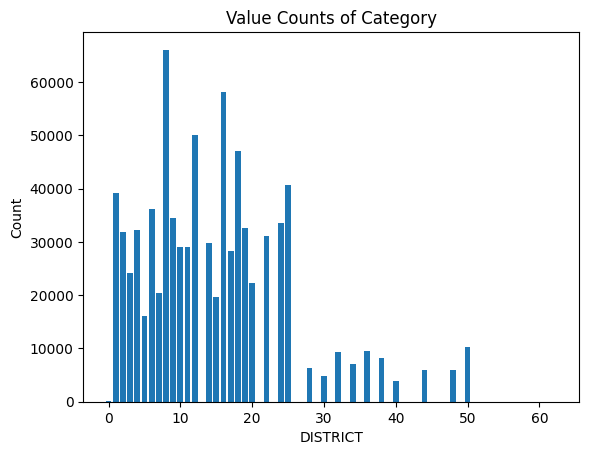

In [ ]:

# Get the value counts of the 'category' column
value_counts = traffic_crashes['IN_DISTRICT'].value_counts()

# Create a bar chart of the value counts
plt.bar(value_counts.index, value_counts.values)
plt.xlabel("DISTRICT")
plt.ylabel("Count")
plt.title("Value Counts of Category")
plt.show()


### [ii] Boxplot of CBD Distance compared to damage reported by the police

In [ ]:
traffic_crashes.describe()

POSTED_SPEED_LIMIT      STREET_NO  BEAT_OF_OCCURRENCE     CRASH_HOUR  \
count       823908.000000  823908.000000       823903.000000  823908.000000   
mean            28.406833    3689.649540         1243.938651      13.198472   
std              6.161524    2885.911034          705.210918       5.570563   
min              0.000000       0.000000          111.000000       0.000000   
25%             30.000000    1250.000000          714.000000       9.000000   
50%             30.000000    3201.000000         1212.000000      14.000000   
75%             30.000000    5600.000000         1822.000000      17.000000   
max             99.000000  451100.000000         6100.000000      23.000000   

       CRASH_DAY_OF_WEEK    CRASH_MONTH       LATITUDE      LONGITUDE  \
count      823908.000000  823908.000000  823908.000000  823908.000000   
mean            4.122318       6.633601      41.857415     -87.678846   
std             1.981011       3.449164       0.085866       0.058819   
min             1.000000       1.000000      41.644670     -87.936193   
25%             2.000000       4.000000      41.783396     -87.721443   
50%             4.000000       7.000000      41.874313     -87.674735   
75%             6.000000      10.000000      41.924204     -87.633791   
max             7.000000      12.000000      42.022780     -87.524587   

          CRASH_YEAR  VEHICLE_COUNT  DISTANCE_FROM_CBD    IN_DISTRICT  
count  823908.000000  823859.000000      823908.000000  823908.000000  
mean     2019.929248       2.040014           8.265540      14.658666  
std         2.286184       0.469106           5.012366      10.149394  
min      2013.000000       1.000000           0.000000       0.000000  
25%      2018.000000       2.000000           4.609160       8.000000  
50%      2020.000000       2.000000           8.656244      14.000000  
75%      2022.000000       2.000000          11.521538      19.000000  
max      2024.000000      18.000000          29.634765      62.000000

In [ ]:
traffic_crashes['DAMAGE'].unique()

array(['OVER $1,500', '$501 - $1,500', '$500 OR LESS'], dtype=object)

In [ ]:
print(traffic_crashes.columns)


Index(['CRASH_RECORD_ID', 'CRASH_DATE', 'POSTED_SPEED_LIMIT',
       'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION',
       'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE',
       'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'REPORT_TYPE',
       'CRASH_TYPE', 'DAMAGE', 'DATE_POLICE_NOTIFIED',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO',
       'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE', 'CRASH_HOUR',
       'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'LATITUDE', 'LONGITUDE', 'LOCATION',
       'CRASH_YEAR', 'VEHICLE_COUNT', 'MULTI_CATEGORICAL',
       'CATEGORICAL_FEATURE', 'h3_index', 'DISTANCE_FROM_CBD',
       'DISCRETIZATION', 'IN_CBD', 'LOCATION_POINTS', 'IN_DISTRICT'],
      dtype='object')


This Chart is for Far distance from the area depending on the central damage
Assessed by the police officer (DAMAGE).
Categories: The x-axis categorizes damage costs into three groups:
Over $1,500
$501 - $1,500
$500 or Less
CBD Distance: The y-axis measures the distance from the CBD, ranging from 0 to 30 units.
Data Representation:
Median: Indicated by a line within each box.
Interquartile Range: The box itself, showing the middle 50% of the data.
Outliers: Individual points outside the ‘whiskers’ of the boxplots.

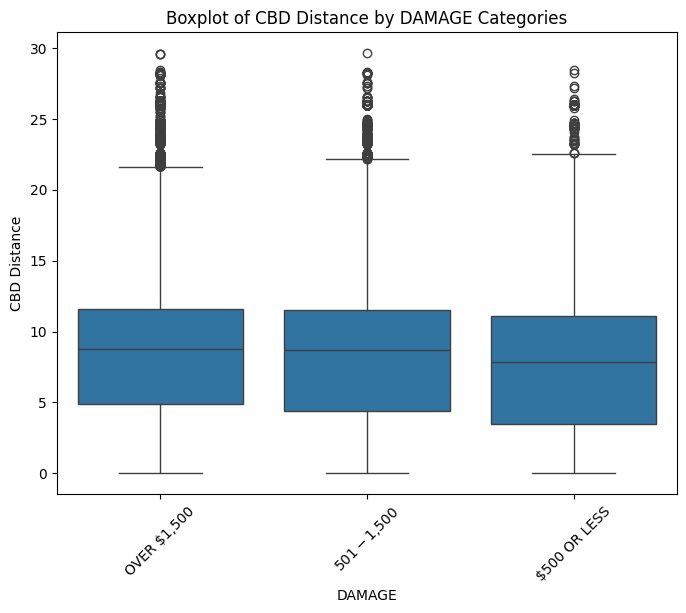

In [ ]:
# Assuming your data frame is called 'df'
plt.figure(figsize=(8, 6))  # Set figure size
sns.boxplot(x='DAMAGE', y='DISTANCE_FROM_CBD', data=traffic_crashes, order=['OVER $1,500', '$501 - $1,500', '$500 OR LESS'])  # Set category order
plt.title('Boxplot of CBD Distance by DAMAGE Categories')
plt.xlabel('DAMAGE')
plt.ylabel('CBD Distance')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.show()

### [iii] Boxplot of street lengths
 

The length of the street within the city. 

Horizontal Axis (LENGTH_KM): Represents the length of streets in kilometers, ranging from 0.0 to 1.6 km.
Data Concentration: The prominent blue bar indicates a concentration of data at a specific length value, suggesting most streets fall within a certain range.
Outliers: Several individual data points extend up to roughly 1.5 km, indicating some streets are significantly longer than the average.

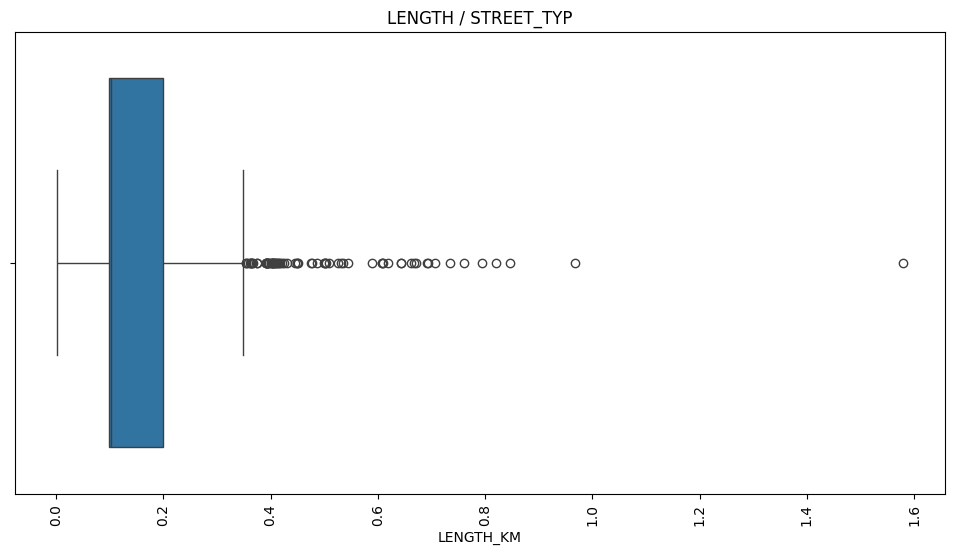

In [ ]:

plt.figure(figsize=(12, 6))
sns.boxplot(x="LENGTH_KM", data=center_lines)
plt.xticks(rotation=90)
plt.title('LENGTH / STREET_TYP')
plt.show()


### [iv] Bar chart of number of crashes compared to street length category

In [ ]:
traffic_crashes['STREET_NO'].value_counts()

STREET_NO
1600     5286
100      4922
800      4815
200      4554
300      4136
         ... 
11487       1
12864       1
2885        1
6293        1
7989        1
Name: count, Length: 11731, dtype: int64

In [ ]:
traffic_crashes['STREET_NO'].isnull().sum()

0

In [ ]:

# Assuming you have a DataFrame named 'traffic_crashes' with a column 'STREET_NO'
value_counts = traffic_crashes['STREET_NO'].value_counts().reset_index()
value_counts.columns = ['STREET_NO', 'COUNT']

print(value_counts)

       STREET_NO  COUNT
0           1600   5286
1            100   4922
2            800   4815
3            200   4554
4            300   4136
...          ...    ...
11726      11487      1
11727      12864      1
11728       2885      1
11729       6293      1
11730       7989      1

[11731 rows x 2 columns]


In [ ]:

# Convert 'STREET_NO' column to integer data type
value_counts['STREET_NO'] = value_counts['STREET_NO'].astype(int)

# Concatenate value_counts with center_lines
merged_data = pd.concat([center_lines, value_counts.set_index('STREET_NO')], axis=1, join='inner')

print(merged_data)

                                                the_geom  FNODE_ID  TNODE_ID  \
0      MULTILINESTRING ((-87.63187018232667 41.780809...     10809     16581   
2      MULTILINESTRING ((-87.68381848191974 41.697243...     15338     22358   
3      MULTILINESTRING ((-87.645841892972 41.69339840...     15799     28881   
4      MULTILINESTRING ((-87.67053671318457 41.679759...     36407     36534   
5      MULTILINESTRING ((-87.62838247953894 41.668860...      9894      5327   
...                                                  ...       ...       ...   
13781  MULTILINESTRING ((-87.67715290991352 41.768403...     14679     33397   
13787  MULTILINESTRING ((-87.65646371084338 41.978201...     26658     32204   
13795  MULTILINESTRING ((-87.70263814028566 41.846364...     24233     18827   
13799  MULTILINESTRING ((-87.77865011821153 42.011990...     25862     12495   
34453  MULTILINESTRING ((-87.53649524648131 41.719528...     22169     22065   

      PRE_DIR STREET_NAM STREET_TYP  ST

In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10110 entries, 0 to 34453
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   the_geom        10110 non-null  object 
 1   FNODE_ID        10110 non-null  int64  
 2   TNODE_ID        10110 non-null  int64  
 3   PRE_DIR         10110 non-null  object 
 4   STREET_NAM      10110 non-null  object 
 5   STREET_TYP      10110 non-null  object 
 6   STREETNAME      10110 non-null  int64  
 7   CLASS           10110 non-null  object 
 8   STATUS          10110 non-null  object 
 9   TIERED          10110 non-null  object 
 10  ONEWAY_DIR      10110 non-null  object 
 11  DIR_TRAVEL      10110 non-null  object 
 12  EWNS            10110 non-null  int64  
 13  F_ZLEV          10110 non-null  int64  
 14  T_ZLEV          10110 non-null  int64  
 15  F_CROSS         10110 non-null  object 
 16  F_CROSS_ST      10110 non-null  int64  
 17  T_CROSS         10110 non-null  obje

In [ ]:
center_lines = merged_data

### [iv] BARPLOT for the number of traffic accidents by street length category.
 

This is A bar plot for the number of traffic accidents by street length category.

Categories: The x-axis, labeled ‘DISCRETIZATION’, has three categories: ‘AVERAGE’, ‘LONG’, and ‘SHORT’.
Values: The y-axis shows the sum of integer values, ranging from 0 to 350,000.
Observations: The ‘AVERAGE’ category has the highest sum, followed by ‘LONG’ and then ‘SHORT’.


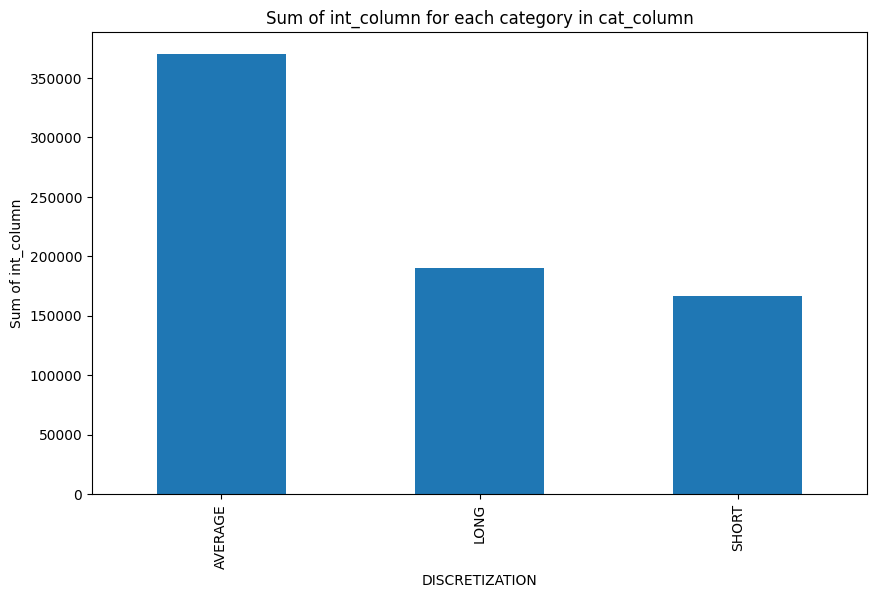

In [ ]:

# Assuming df is your dataframe and 'int_column' is your integer column and 'cat_column' is your categorical column
grouped = center_lines.groupby('DISCRETIZATION')['COUNT'].sum()

# Create bar chart
plt.figure(figsize=(10,6))
grouped.plot(kind='bar')
plt.ylabel('Sum of int_column')
plt.title('Sum of int_column for each category in cat_column')
plt.show()


### [v] Bar Chart of number of crashes compared to distance to cbd category

THis is a bar chart of of number of crashes compared to distance to cbd category
Categories: The x-axis, labeled DISTANCE TO CBD, has three categories: ‘AVERAGE’, ‘LONG’, and ‘SHORT’.
Values: The y-axis shows the sum of integer values, ranging from 0 to 350,000. labeled as count
Summary: The ‘AVERAGE’ category has the highest sum, followed by ‘LONG’ and then ‘SHORT’.

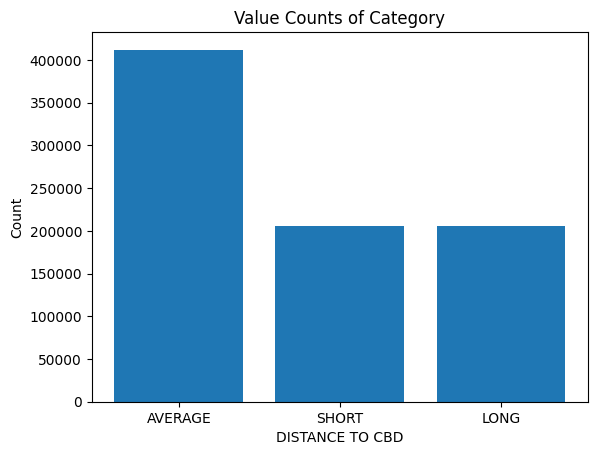

In [ ]:
# Get the value counts of the 'category' column
value_counts = traffic_crashes['DISCRETIZATION'].value_counts()

# Create a bar chart of the value counts
plt.bar(value_counts.index, value_counts.values)
plt.xlabel("DISTANCE TO CBD")
plt.ylabel("Count")
plt.title("Value Counts of Category")
plt.show()


### [vi] is there a relevance between a street length category and cbd distance category? (Chi Square Analysis)

In [ ]:
def calculate_cbd_distance_by_line(line):
    line = loads(line)
    multilinestring_projected = transform(lambda x, y: project(x, y), line)
            # point_projected = transform(lambda x, y: project(x, y), point)

    # Calculate the minimum distance from the MultiLineString to the cbd_projected
    distance = multilinestring_projected.distance(cbd_projected) / 1000
    return distance

In [ ]:
center_lines['the_geom'].unique()

array(['MULTILINESTRING ((-87.63187018232667 41.78080974837663, -87.63184648290574 41.78038242747728, -87.63184504581191 41.78035651260306, -87.63184150678558 41.78020488487632))',
       'MULTILINESTRING ((-87.68381848191974 41.69724384520839, -87.68380865934144 41.6969895939359, -87.6838043382271 41.69684406497762, -87.68379891868663 41.696662139950185, -87.68379159024295 41.69640791839054, -87.68378572420373 41.69619031449198, -87.68378183438702 41.69604654432406, -87.68377581733701 41.695821173094146, -87.68376644518884 41.69556993126857, -87.68376222735108 41.69541837437925))',
       'MULTILINESTRING ((-87.645841892972 41.693398401222005, -87.6462427106735 41.69310679196475))',
       ...,
       'MULTILINESTRING ((-87.70263814028566 41.84636486780407, -87.70287366020453 41.846362210761924, -87.7030030407657 41.84636146642149, -87.70319563132793 41.84635972405686, -87.70342108018913 41.8463569266636, -87.70364649260554 41.8463541011853, -87.70386083348596 41.846349676427))',
    

In [ ]:
center_lines['DISTANCE_TO_CBD'] = center_lines['the_geom'].apply(calculate_cbd_distance_by_line)

In [ ]:
# Calculate quartiles
q1 = center_lines['DISTANCE_TO_CBD'].quantile(0.25)
q3 = center_lines['DISTANCE_TO_CBD'].quantile(0.75)

In [ ]:
center_lines['CBD_DISTANCE_DISCRITIZE'] = center_lines['DISTANCE_TO_CBD'].apply(discretize)

In [ ]:

# Creating a contingency table
contingency_table = pd.crosstab(center_lines['DISCRETIZATION'], center_lines['CBD_DISTANCE_DISCRITIZE'])

# Performing the Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Output the results
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print(f"Expected frequencies:\n{expected}")


Chi-square statistic: 342.24074637138006
P-value: 8.302300781795114e-73
Degrees of freedom: 4
Expected frequencies:
[[2538.99762611 1270.00118694 1270.00118694]
 [1306.24154303  653.37922849  653.37922849]
 [1208.76083086  604.61958457  604.61958457]]


In [ ]:
center_lines.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10110 entries, 0 to 34453
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   the_geom                 10110 non-null  object 
 1   FNODE_ID                 10110 non-null  int64  
 2   TNODE_ID                 10110 non-null  int64  
 3   PRE_DIR                  10110 non-null  object 
 4   STREET_NAM               10110 non-null  object 
 5   STREET_TYP               10110 non-null  object 
 6   STREETNAME               10110 non-null  int64  
 7   CLASS                    10110 non-null  object 
 8   STATUS                   10110 non-null  object 
 9   TIERED                   10110 non-null  object 
 10  ONEWAY_DIR               10110 non-null  object 
 11  DIR_TRAVEL               10110 non-null  object 
 12  EWNS                     10110 non-null  int64  
 13  F_ZLEV                   10110 non-null  int64  
 14  T_ZLEV                   10

### [vii] Conclusion

#### Here is our Conclusion:
The varying numbers of traffic accidents across different districts shown in this chart could reflect the population density, traffic volume, or the presence of high-risk intersections. Districts with higher accident counts might require targeted safety measures or infrastructure improvements.

Also The ‘AVERAGE’ category having the highest sum might indicate that most of the integer values (possibly representing things like traffic counts, accident numbers, or other urban metrics) are concentrated around a mean or typical value. The ‘LONG’ and ‘SHORT’ categories could represent extremes that are less common but still significant.

MoreOver The concentration of data around a specific length value indicates that most streets within the city have a uniform length, likely due to standardized urban planning. The outliers suggest that there are some exceptionally long streets, which could be main thoroughfares or avenues designed to connect different parts of the city.


And The traffic accidents with higher damage costs tend to occur slightly farther from the central business district (CBD). This could be due to higher-speed roads or less congested areas where collisions have a greater impact.

## [d] Passengers Cases Analysis


### [i]

In [ ]:
df_drivers =traffic_crashes_people[traffic_crashes_people['PERSON_TYPE'] == "DRIVER"]

In [ ]:
# Merge traffic_crashes_vehicles with traffic_crashes_people on VEHICLE_ID
merged_df = pd.merge(df_drivers, traffic_crashes_vehicles[['VEHICLE_ID', 'VEHICLE_AGE','VEHICLE_AGE_NUM']], on='VEHICLE_ID', how='left')

# Display the first few rows of the merged dataframe to verify the merge
print(merged_df[['VEHICLE_ID', 'AGE', 'SEX', 'VEHICLE_AGE_NUM','VEHICLE_AGE']].head())

   VEHICLE_ID   AGE SEX  VEHICLE_AGE_NUM VEHICLE_AGE
0    834816.0  25.0   M              3.0         New
1    827212.0  37.0   M              6.0         New
2      9579.0   NaN   X              1.0         New
3      9598.0   NaN   X              1.0         New
4      9600.0   NaN   X              1.0         New


THE SCATTER PLOT :
Here is a description 
Age Distribution: The majority of drivers involved in accidents are represented near the top of the graph, indicating they are younger with newer vehicles.
Gender Representation: Blue squares (males) and green triangles (females) are used to differentiate gender, with no significant pattern suggesting one gender is more involved in accidents than the other.
Older Vehicles: A cluster of points at the bottom right, with negative values on both axes, shows older drivers with much older vehicles involved in accidents.
Data Range: The x-axis (Age of Person) ranges from -150 to 100, which may indicate incorrect data entry, as ages below 0 or above 100 are unlikely. The y-axis (Vehicle Age) ranges from 0 to -8000, suggesting a need to verify the data for possible errors.

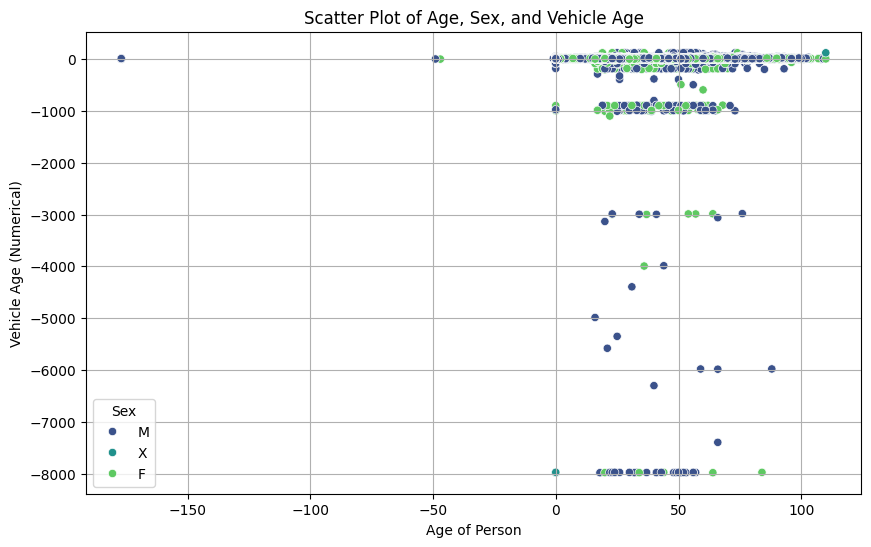

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='AGE', y='VEHICLE_AGE_NUM', hue='SEX', data=merged_df, palette='viridis')

# Set plot labels and title
plt.xlabel('Age of Person')
plt.ylabel('Vehicle Age (Numerical)')
plt.title('Scatter Plot of Age, Sex, and Vehicle Age')
plt.legend(title='Sex')
plt.grid(True)
plt.show()

### [ii] is there a relation between the age class of the driver and the car age class?

In [ ]:
# Define the discretization function
def classify_age(value):
  if value < 26:
    return 'YOUNG'
  elif value <= 50:
    return 'MATURE'
  else:
    return 'OLD'

In [ ]:
merged_df['PERSON_CLASS_AGE'] = merged_df['AGE'].apply(classify_age)
merged_df['PERSON_CLASS_AGE'].value_counts()

PERSON_CLASS_AGE
OLD       15155930
MATURE     9983352
YOUNG      3160027
Name: count, dtype: int64

In [ ]:
contingency_table = pd.crosstab(merged_df['PERSON_CLASS_AGE'], merged_df['VEHICLE_AGE'])

contingency_table

VEHICLE_AGE            New     Old  Vintage
PERSON_CLASS_AGE                           
MATURE             9468296  514042     1014
OLD               14458525  695852     1553
YOUNG              2972590  187146      291

In [ ]:
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

print("Chi-square statistic:", chi2_stat)
print("P-value:", p_val)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

Chi-square statistic: 11354.992928773518
P-value: 0.0
Degrees of freedom: 4
Expected frequencies:
 [[9.48949985e+06 4.92843909e+05 1.00823734e+03]
 [1.44062030e+07 7.48196376e+05 1.53062564e+03]
 [3.00370815e+06 1.55999714e+05 3.19137021e+02]]


In [ ]:
if p_val < 0.05:
    print("There is a significant association between age of driver and categorical age of car.")
else:
    print("There is no significant association between age of driver and categorical age of car.")

There is a significant association between age of driver and categorical age of car.


### [iii]

Box Chart For Represents the distribution of the average age of passengers, excluding the driver. Here’s an explanation of the box plot elements:

Minimum Age: The lowest value at the beginning of the left whisker, which could be around -50 based on the axis (this may indicate incorrect data or outliers).
First Quartile (Q1): The left edge of the box, indicating that 25% of the data is below this value.
Median (Q2): The line within the box, representing the median age of the dataset.
Third Quartile (Q3): The right edge of the box, indicating that 75% of the data is below this value.
Maximum Age: The highest value at the end of the right whisker, which could be around 100 based on the axis.

In [ ]:
layout_options = {
    'paper_bgcolor':"#383838",
    'plot_bgcolor':'#383838',
    'title_font': dict(color='white'),
    'legend_font': dict(color='white'),
    'yaxis':dict(color="white"),
    'xaxis':dict(color="white")
    }

In [ ]:
m_age_p = df_passenger[["VEHICLE_ID","AGE"]].copy()
df_passenger[["VEHICLE_ID","AGE"]].copy()

m_age_p = m_age_p.groupby(['VEHICLE_ID']).agg({'AGE': 'mean'})
m_age_p

AGE
VEHICLE_ID           
28.0        45.500000
32.0        47.000000
33.0        23.333333
58.0         5.000000
59.0        69.000000
...               ...
1712792.0   28.000000
1712811.0   53.000000
1712822.0         NaN
1712853.0   19.000000
1712855.0         NaN

[248592 rows x 1 columns]

In [ ]:
fig = px.box(m_age_p, y="AGE")
fig.update_layout(**layout_options)
fig.show()

### [iv] Box Chart For the number of passengers excluding the driver (or explaining the description table attribute)

Minimum: The lowest value at the beginning of the left whisker, which indicates the smallest number of passengers recorded.
First Quartile (Q1): The left edge of the box, indicating that 25% of the data is below this value.
Median: The line within the box, representing the median number of passengers.
Third Quartile (Q3): The right edge of the box, indicating that 75% of the data is below this value.
Maximum: The highest value at the end of the right whisker, which indicates the largest number of passengers recorded.
Outliers: Individual points that are located above Q3, which represent unusually high numbers of passengers.

In [ ]:
count_p = df_passenger[["VEHICLE_ID","PERSON_ID"]].copy()

count_p = count_p.groupby(['VEHICLE_ID']).agg({'PERSON_ID': 'count'})
count_p

PERSON_ID
VEHICLE_ID           
28.0                2
32.0                1
33.0                3
58.0                3
59.0                1
...               ...
1712792.0           1
1712811.0           1
1712822.0           3
1712853.0           3
1712855.0           2

[248592 rows x 1 columns]

In [ ]:
fig = px.box(count_p, y="PERSON_ID")
fig.update_layout(**layout_options)
fig.show()

### [v] Draw a Bar chart for the vehicle's age class

New Vehicles: The bar for ‘New’ vehicles reaches nearly to the 1M mark, indicating a large number of new vehicles.
Old Vehicles: The bar for ‘Old’ vehicles reaches just over the 400,000 mark, showing a significant but smaller number of older vehicles.
Vintage Vehicles: There is no bar present for ‘Vintage’ vehicles, suggesting there are none in this dataset.

In [ ]:
car_ages = traffic_crashes_vehicles[["VEHICLE_AGE","VEHICLE_ID"]].copy()

car_ages = car_ages.groupby(['VEHICLE_AGE'], as_index=False).count()[['VEHICLE_AGE','VEHICLE_ID']].rename({'VEHILCE_ID': 'count'},axis = 1)
car_ages

VEHICLE_AGE  VEHICLE_ID
0         New     1092968
1         Old      545955
2     Vintage        3496

In [ ]:
fig = px.bar(car_ages, x='VEHICLE_AGE', y='VEHICLE_ID', color_discrete_map={False: px.colors.qualitative.Plotly[1], True: px.colors.qualitative.Plotly[0]}, barmode='group')
fig.update_layout(**layout_options)
fig.show()

### [vi] Conclusion

The scatter plot suggests that most accidents involve newer vehicles, which could indicate that vehicle age might not be a significant factor in accidents.
The distribution of accidents across driver’s ages and genders appears relatively even, suggesting no particular age or gender is more prone to accidents.
The cluster of older drivers with older vehicles involved in accidents could point to potential issues like slower reaction times or outdated vehicle safety features.

The box plot shows a median close to zero, which is unusual and likely indicates data entry errors.
If we assume the data is correct, a median age near zero would suggest that passengers are typically very young, which might be the case in certain contexts like school transportation.


The median number of passengers is 1, indicating that it’s most common to have one passenger excluding the driver.
The presence of outliers suggests that there are instances with a very high number of passengers, which could occur in situations like carpooling or in commercial vehicles like taxis and buses.

The bar chart shows a predominance of new vehicles, which could reflect recent trends in vehicle purchases or a dataset focused on a specific vehicle fleet.
The absence of vintage vehicles might indicate a modern fleet or that such vehicles are not commonly used or included in the dataset.


## [e] Outlier Detection

### [i]

## in traffic crashes & vehicles

In [ ]:
def detect_outliers(df, column):
  mean = df[column].mean()
  std = df[column].std()
  df[column + '_z_scores'] = df[column].apply(lambda x: abs(x - mean) / std)
  return df[df[column + '_z_scores'] > 3][column]

In [ ]:
detect_outliers(traffic_crashes,'BEAT_OF_OCCURRENCE')
detect_outliers(traffic_crashes,'CRASH_HOUR')
detect_outliers(traffic_crashes,'CRASH_DAY_OF_WEEK')
detect_outliers(traffic_crashes,'CRASH_MONTH')

Series([], Name: CRASH_MONTH, dtype: int64)

##### The reason of outlier for this Column called LONGITUDE isnot get the LONGITUDE for the location 


In [ ]:
detect_outliers(traffic_crashes,'LONGITUDE')

566      -87.933994
610      -87.933994
763      -87.933994
855      -87.933994
956      -87.933994
            ...    
821928   -87.886333
822381   -87.905309
822971   -87.884689
823251   -87.905309
823265   -87.876156
Name: LONGITUDE, Length: 2108, dtype: float64

##### The reason of outlier for this Column called LATITUDE isnot get the LATITUDE for the location 


In [ ]:
detect_outliers(traffic_crashes,'LATITUDE')


Series([], Name: LATITUDE, dtype: float64)

##### The reason of outlier for this Column called VEHICLE_YEAR is filled the data quickly or without pay attention for it


C:\Users\moazh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



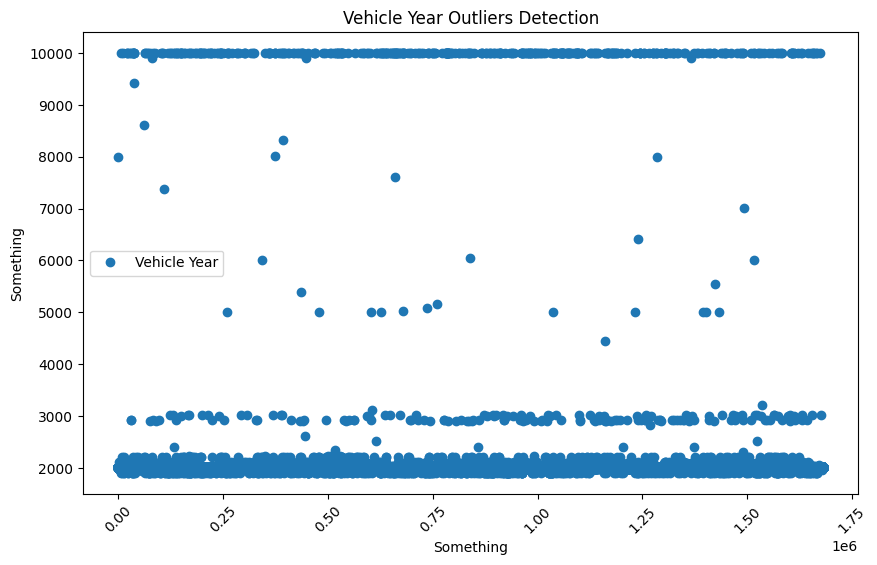

142        8001.0
5098       9999.0
11040      9999.0
20611      9999.0
20949      9999.0
            ...  
1658851    9999.0
1663453    9999.0
1666422    9999.0
1674080    9999.0
1675894    3013.0
Name: VEHICLE_YEAR, Length: 589, dtype: float64

In [ ]:
outliers= detect_outliers(traffic_crashes_vehicles,'VEHICLE_YEAR')
plt.figure(figsize=(10, 6))
plt.plot(range(len(traffic_crashes_vehicles['VEHICLE_YEAR'])), traffic_crashes_vehicles['VEHICLE_YEAR'], marker='o', linestyle='', label='Vehicle Year')
plt.xlabel("Something")
plt.ylabel("Something")
plt.title('Vehicle Year Outliers Detection')
plt.legend()
plt.xticks(rotation=45)
plt.show()
display(outliers)

In [ ]:
detect_outliers(traffic_crashes_vehicles,'UNIT_NO')
detect_outliers(traffic_crashes_vehicles,'VEHICLE_ID')

Series([], Name: VEHICLE_ID, dtype: float64)

### [ii] Reason for outliers

The reason for the extremity of these data is either rapid entry or a lack of attention to entering real data, especially since there are many empty data entries. This also leads us to doubt that the data may not be 100% accurate.

# Question [4]: Do What you Have to Do

In [ ]:
def drawDis(position,column,color):
    plt.subplot(3, 3, position)
    plt.hist(traffic_crashes[column],
         bins=10, color=color, alpha=0.7)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

STREET_DIRECTION
W    294590
S    275840
N    197482
E     55992
Name: count, dtype: int64


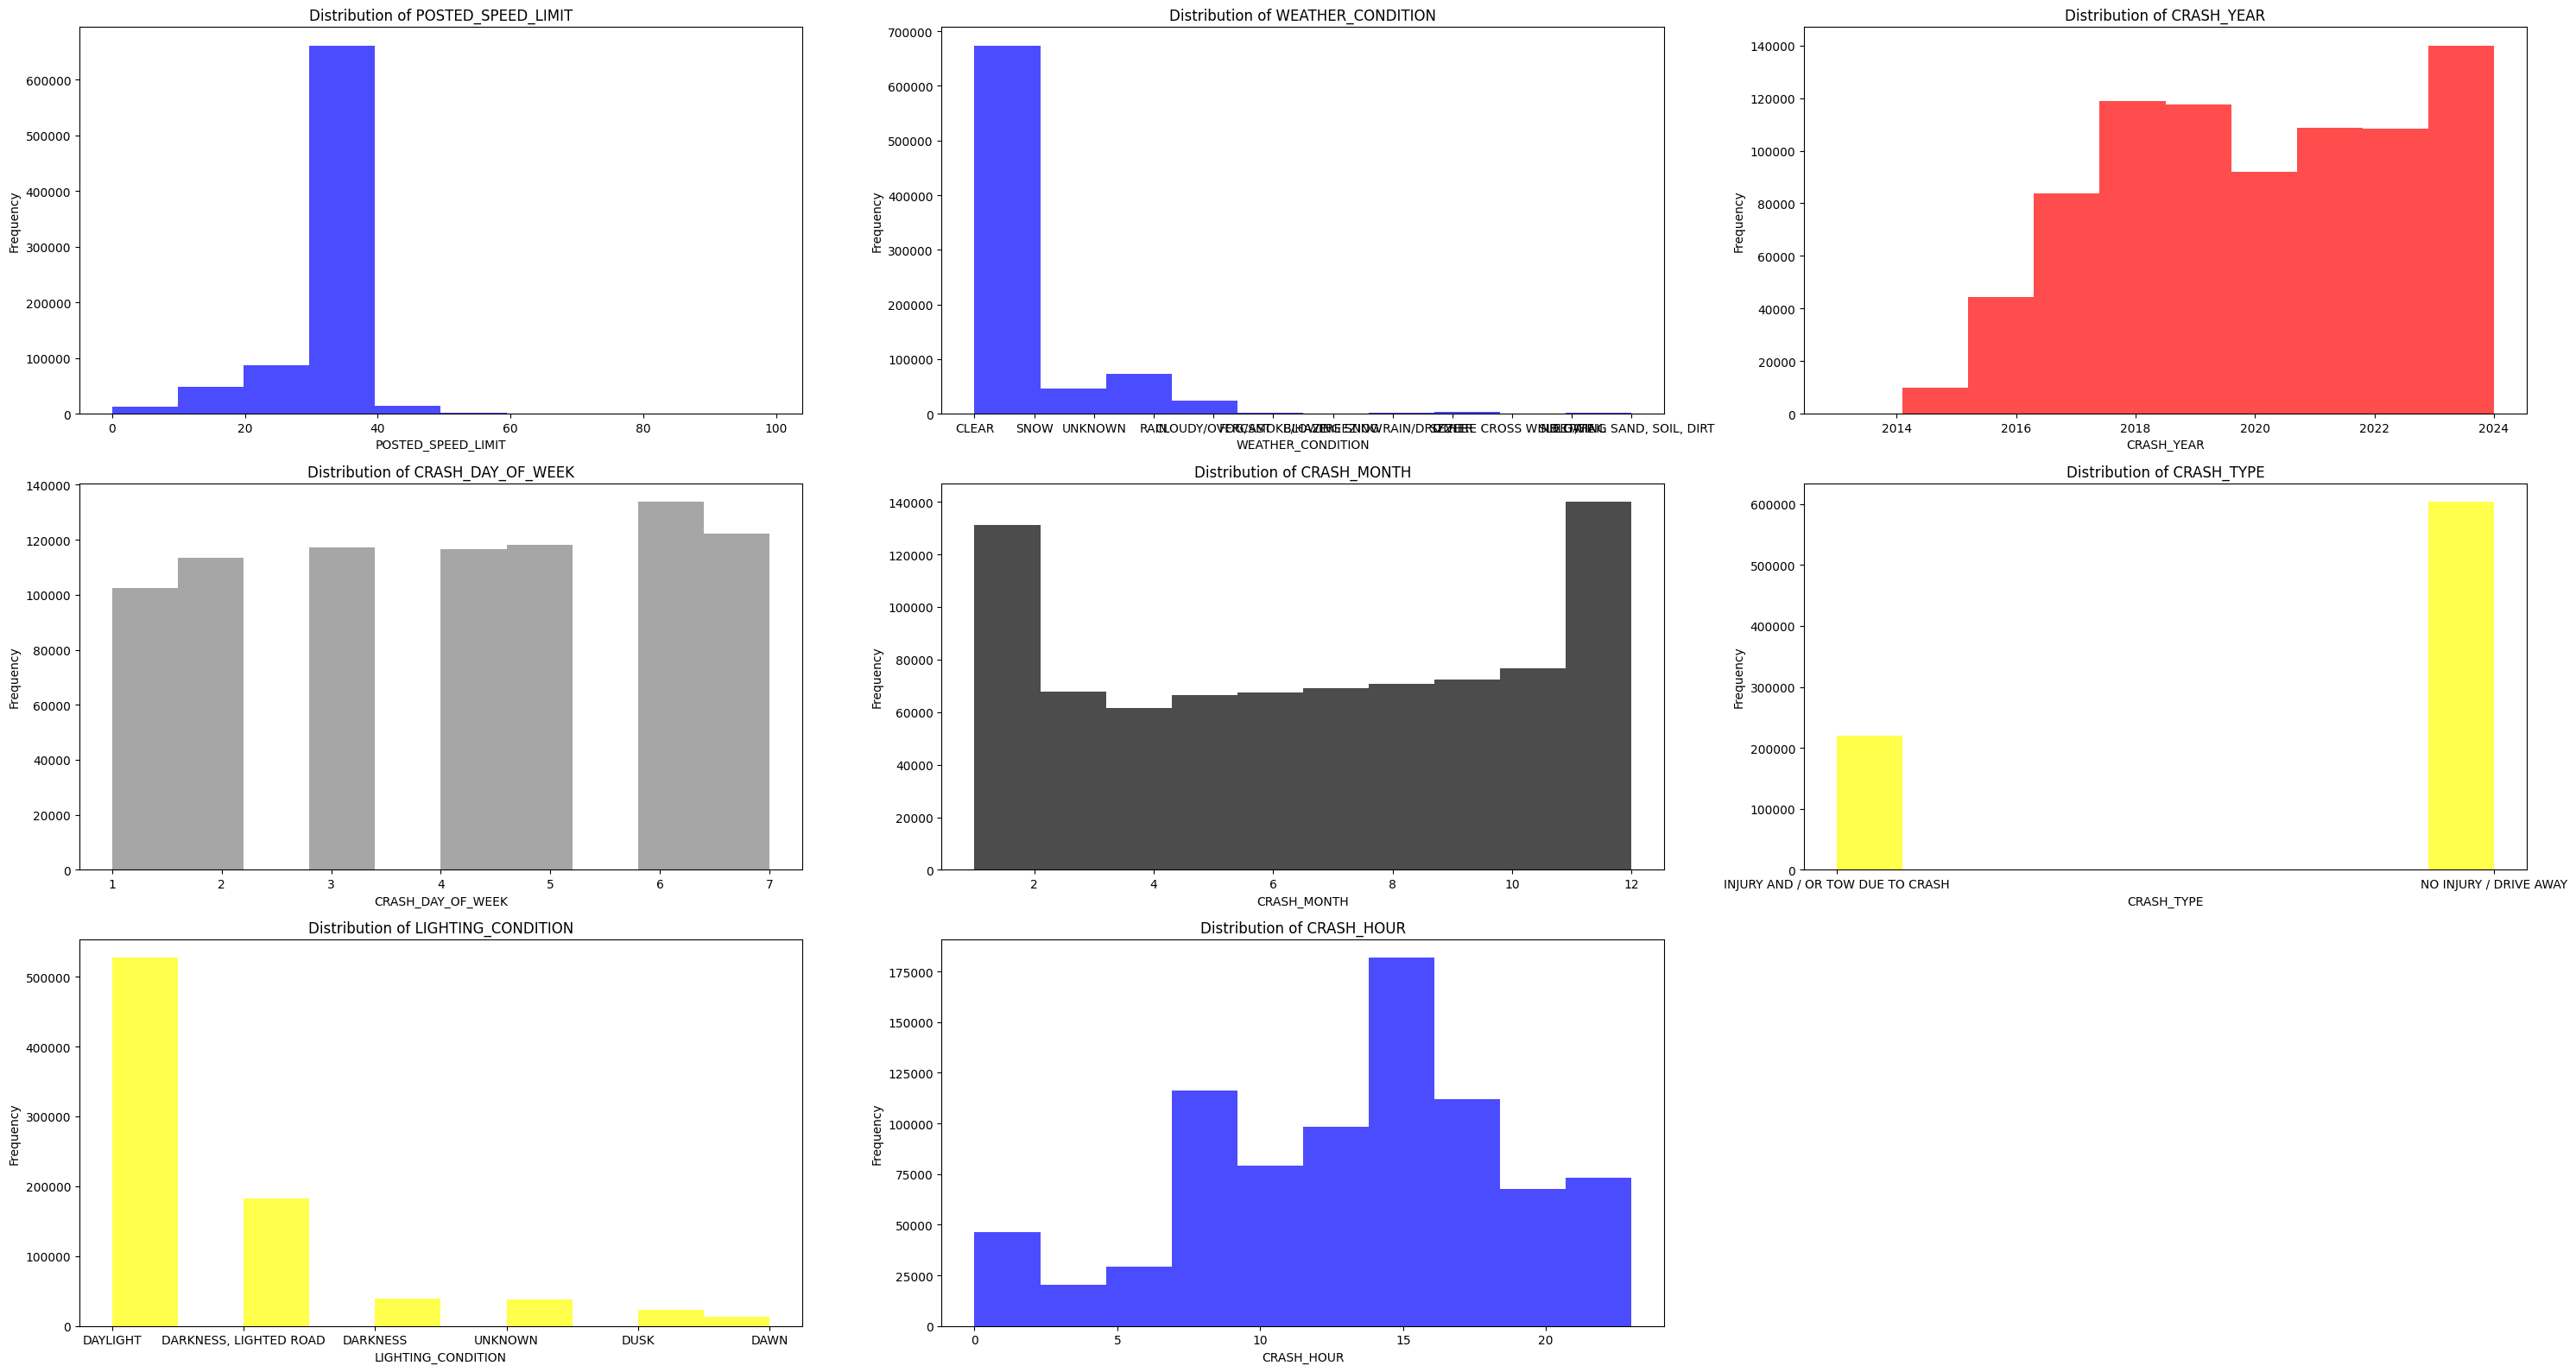

POSTED_SPEED_LIMIT     CRASH_YEAR  BEAT_OF_OCCURRENCE  \
count       823908.000000  823908.000000       823903.000000   
mean            28.406833    2019.929248         1243.938651   
std              6.161524       2.286184          705.210918   
min              0.000000    2013.000000          111.000000   
25%             30.000000    2018.000000          714.000000   
50%             30.000000    2020.000000         1212.000000   
75%             30.000000    2022.000000         1822.000000   
max             99.000000    2024.000000         6100.000000   

       CRASH_DAY_OF_WEEK    CRASH_MONTH  
count      823908.000000  823908.000000  
mean            4.122318       6.633601  
std             1.981011       3.449164  
min             1.000000       1.000000  
25%             2.000000       4.000000  
50%             4.000000       7.000000  
75%             6.000000      10.000000  
max             7.000000      12.000000

In [ ]:


stats = traffic_crashes[['POSTED_SPEED_LIMIT',
                         'CRASH_YEAR', 'BEAT_OF_OCCURRENCE', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH']].describe()

plt.figure(figsize=(30, 16))
drawDis(1, 'POSTED_SPEED_LIMIT', 'blue')
drawDis(2, 'WEATHER_CONDITION', 'blue')
drawDis(3, 'CRASH_YEAR', 'red')
drawDis(4, 'CRASH_DAY_OF_WEEK', 'grey')
drawDis(5, 'CRASH_MONTH', 'black')
drawDis(6, 'CRASH_TYPE', 'yellow')
drawDis(7, 'LIGHTING_CONDITION', 'yellow')
drawDis(8, 'CRASH_HOUR', 'blue')
# drawDis(9, 'STREET_DIRECTION', 'yellow')
print(traffic_crashes['STREET_DIRECTION'].value_counts())
plt.tight_layout()
plt.show()

stats

When examining the traffic crashes, we can extract a lot of information, but upon closer inspection, it appears that crashes are more frequent on holidays. Notice the CRASH_MONTH plot: crashes seem to be higher in the first two months and also in December. This is due to their holidays, such as New Year's and Halloween, and similar occasions. Meanwhile, crashes are less frequent during the rest of the year.

### In ARABIC

اكثر حالات الاصطدام تمت بالنهار وباخر ساعاته قبل الغروب وبعد العصر وايضا الاغلبية من انواع الاصطدام هي مركبة متوقفة ونهاية السيارات 
وتحول وزواية وحالات الطقس الغالبية العظمى ايضا الجو صحو
واذا قمنا بجمعهن كلهن نلاحظ ان اسباب الحوادث ليست متوفرة مثلاا حالات الطقس او الرؤية كأن ان يكون الجو ضباب مثلا ونلاحظ ان غالبية الحوادث تمت في حالات قيادة جيدة لكن ايضا يمكننا ان نلاحظ ان حالات الحوادث تكون مرتفعة في ساعات مغادرة العمل مما يقودنا الى ان اسباب الحوادث هي الارهاق والتعب وضغط العمل سيما ان حالات الاصطدام المتكررة بكثرة هي نهاية خلفية او مركبة متوقفة وهذا ايضا يجعلنا ان ندعم ملاحظتنا ان الارهاق وقلة التركيز في ساعات مغادرة العمل هي مسببة لكثرة الحوادث 
لانقول ان ظروف الطقس او الرؤية او الظلام ليس فيها حوادث ابدا كلا لكن نسبتها اقل ويعود ذلك الى ان الانسان عندما يرى ان حالات الجو غير مستقرة مثل الضباب او القيادة ليلا يجعله يركز اكثر في القيادة بينما تبين لنا العكس 
وعطفا ع الاستنتاج السابق ان حالات الحوادث تزداد في ايام العطل والاعياد وهذا يقودنا الى ان نسبة شرب الكحول والمسكرات في هذا الوقت تزداد مما ايضا يجعله سبب اخر لزيادة الحوادث بجانب الارهاق والتعب وقلة التركيز في ساعات الدوام الاخيرة

#### In English 

#### Most collisions occur during the day, particularly in the last hours before sunset and late afternoon. The majority of these collisions involve parked vehicles, rear-end collisions, turns, and angles. Additionally, the vast majority of weather conditions during these collisions are clear skies.

#### When we analyze these incidents, we notice that typical accident causes, such as weather conditions or visibility issues like fog, are not present. Most accidents occur under good driving conditions. However, we can also observe that accident rates are high during the hours when people are leaving work. This leads us to conclude that the causes of these accidents are fatigue, exhaustion, and work pressure. This is especially evident given the high frequency of rear-end collisions and accidents involving parked vehicles. This supports our observation that fatigue and lack of concentration during the hours after work contribute significantly to the number of accidents.

#### We do not claim that weather conditions, visibility, or darkness do not cause accidents at all—they do, but their percentage is lower. This is because when people see that weather conditions are unstable, such as in foggy conditions or at night, they tend to concentrate more on their driving. Conversely, under good conditions, people may be less focused.

#### Additionally, accidents increase on holidays and festive days. This suggests that the consumption of alcohol and intoxicants rises during these times, which is another reason for the increase in accidents, alongside fatigue and lack of concentration during the last hours of the workday.

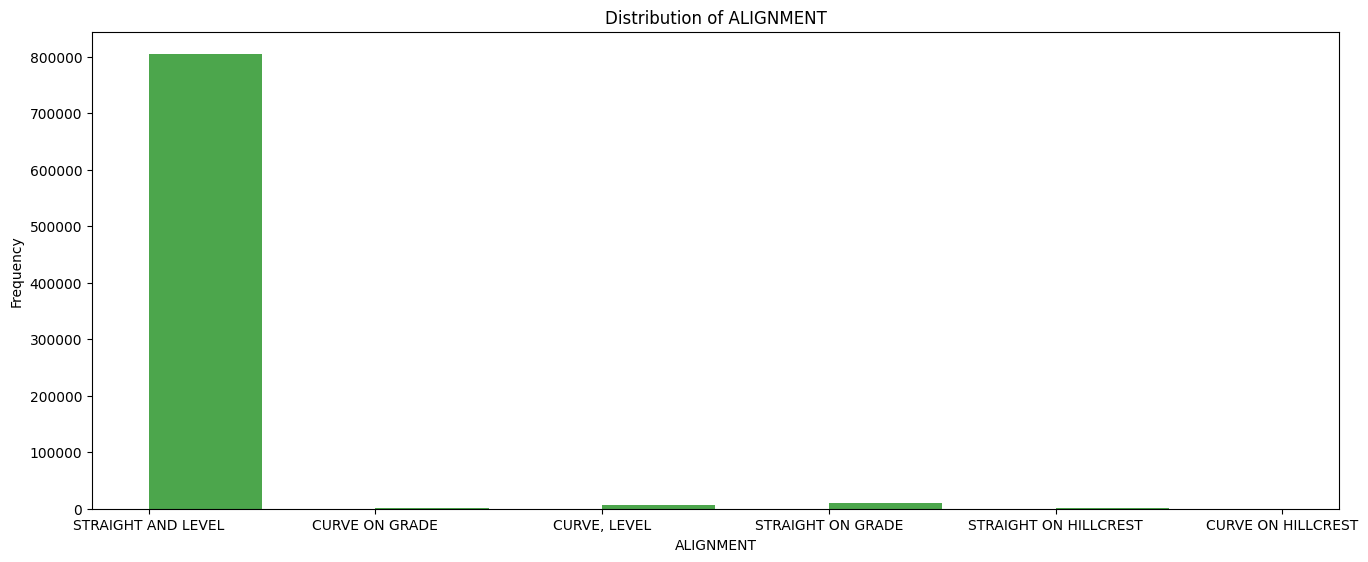

ALIGNMENT
STRAIGHT AND LEVEL       803950
STRAIGHT ON GRADE         10249
CURVE, LEVEL               5945
STRAIGHT ON HILLCREST      2160
CURVE ON GRADE             1238
CURVE ON HILLCREST          366
Name: count, dtype: int64

In [ ]:
plt.figure(figsize=(40, 16))
drawDis(3,'ALIGNMENT','green')
plt.tight_layout()
plt.show()
traffic_crashes['ALIGNMENT'].value_counts()